In [2]:
import logging
import re

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
from tqdm import tqdm

nltk.download("stopwords")
from nltk.corpus import stopwords

russian_stopwords = stopwords.words("russian")

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import FunctionTransformer

# Настройка логирования
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)
logger = logging.getLogger(__name__)


# ========================
# Трансформер для извлечения экстра признаков из одной текстовой колонки
# (например, для subject или description)
# ========================
class ExtraTextFeaturesSingle(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        features = []
        # X ожидается как последовательность строк (Series)
        for text in X:
            text = text if isinstance(text, str) else ""
            word_count = len(text.split())
            char_count = len(text)
            url_present = 1 if re.search(r"http[s]?://", text) else 0
            features.append([word_count, char_count, url_present])
        return np.array(features)


# ========================
# Пайплайны для текстовых признаков с TF-IDF
# Добавлен параметр max_features для ограничения количества фичей
# ========================
subject_tfidf_pipeline = Pipeline(
    [
        ("selector", FunctionTransformer(lambda x: x["subject"], validate=False)),
        (
            "tfidf",
            TfidfVectorizer(
                stop_words=russian_stopwords, lowercase=True, max_features=500
            ),
        ),
    ]
)

desc_tfidf_pipeline = Pipeline(
    [
        ("selector", FunctionTransformer(lambda x: x["description"], validate=False)),
        (
            "tfidf",
            TfidfVectorizer(
                stop_words=russian_stopwords, lowercase=True, max_features=500
            ),
        ),
    ]
)

# ========================
# Пайплайны для экстра признаков по отдельности
# ========================
subject_extra_pipeline = Pipeline(
    [
        ("selector", FunctionTransformer(lambda x: x["subject"], validate=False)),
        ("extra", ExtraTextFeaturesSingle()),
    ]
)

desc_extra_pipeline = Pipeline(
    [
        ("selector", FunctionTransformer(lambda x: x["description"], validate=False)),
        ("extra", ExtraTextFeaturesSingle()),
    ]
)

# Объединяем все признаки
features_union = FeatureUnion(
    [
        ("subject_tfidf", subject_tfidf_pipeline),
        ("desc_tfidf", desc_tfidf_pipeline),
        ("subject_extra", subject_extra_pipeline),
        ("desc_extra", desc_extra_pipeline),
    ]
)

# ========================
# Полный пайплайн: признаки + классификатор
# ========================
pipeline = Pipeline(
    [("features", features_union), ("clf", LogisticRegression(solver="liblinear"))]
)

# ========================
# Расширенный набор гиперпараметров для GridSearchCV
# ========================
param_grid = {
    "clf__C": [0.01, 0.1, 1, 10, 100],
    "clf__penalty": ["l1", "l2"],
    "features__subject_tfidf__tfidf__ngram_range": [(1, 1), (1, 2)],
    "features__subject_tfidf__tfidf__max_features": [500, 1000],
    "features__desc_tfidf__tfidf__ngram_range": [(1, 1), (1, 2)],
    "features__desc_tfidf__tfidf__max_features": [500, 1000],
}

# ========================
# Загрузка и подготовка данных
# Предполагается, что данные содержатся в CSV-файле с колонками: 'subject', 'description', 'class'
# ========================
logger.info("Загрузка данных...")
data = pd.read_csv("../data/df.csv")  # замените 'data.csv' на путь к вашим данным

# Заполнение пустых значений специальными значениями
data["subject"] = data["subject"].fillna("no_subject")
data["description"] = data["description"].fillna("no_description")

X = data[["subject", "description"]]
y = data["class"]  # классы должны быть бинарными (например, 0 и 1)

# Разбивка на обучающую и отложенную выборки
logger.info("Разбивка данных на train и test...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ========================
# Поиск лучших гиперпараметров с помощью GridSearchCV
# ========================
logger.info("Запуск GridSearchCV...")
grid = GridSearchCV(pipeline, param_grid, cv=5, scoring="roc_auc", n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)
logger.info("GridSearchCV завершён.")
logger.info(f"Лучшие гиперпараметры: {grid.best_params_}")

# ========================
# Валидация на отложенной выборке
# ========================
logger.info("Валидация на отложенной выборке...")
y_pred = grid.predict(X_test)
y_proba = grid.predict_proba(X_test)[:, 1]

logger.info("\nОтчёт по классификации:")
print(classification_report(y_test, y_pred))
logger.info(f"ROC AUC: {roc_auc_score(y_test, y_proba)}")

[nltk_data] Downloading package stopwords to /home/vadim/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
2025-02-27 10:53:29,708 - INFO - Загрузка данных...
2025-02-27 10:53:29,971 - INFO - Разбивка данных на train и test...
2025-02-27 10:53:29,977 - INFO - Запуск GridSearchCV...


Fitting 5 folds for each of 160 candidates, totalling 800 fits


/media/admin01/storage4/vadim/request_classifier/.venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/media/admin01/storage4/vadim/request_classifier/.venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/media/admin01/storage4/vadim/request_classifier/.venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the cu

               precision    recall  f1-score   support

itsm_incident       0.69      0.48      0.57      2737
 itsm_request       0.79      0.90      0.84      5901

     accuracy                           0.77      8638
    macro avg       0.74      0.69      0.71      8638
 weighted avg       0.76      0.77      0.76      8638



In [3]:
import logging

import nltk
import pandas as pd

nltk.download("stopwords")
from nltk.corpus import stopwords

russian_stopwords = stopwords.words("russian")

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import FunctionTransformer

re
# Настройка логирования
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)
logger = logging.getLogger(__name__)


# ========================
# Трансформер для извлечения экстра признаков из одной текстовой колонки
# (например, для subject или description)
# ========================
class ExtraTextFeaturesSingle(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        features = []
        # X ожидается как последовательность строк (Series)
        for text in X:
            text = text if isinstance(text, str) else ""
            word_count = len(text.split())
            char_count = len(text)
            url_present = 1 if re.search(r"http[s]?://", text) else 0
            features.append([word_count, char_count, url_present])
        return np.array(features)


# ========================
# Пайплайны для текстовых признаков с TF-IDF
# Добавлен параметр max_features для ограничения количества фичей
# ========================
subject_tfidf_pipeline = Pipeline(
    [
        ("selector", FunctionTransformer(lambda x: x["subject"], validate=False)),
        (
            "tfidf",
            TfidfVectorizer(
                stop_words=russian_stopwords, lowercase=True, max_features=500
            ),
        ),
    ]
)

desc_tfidf_pipeline = Pipeline(
    [
        ("selector", FunctionTransformer(lambda x: x["description"], validate=False)),
        (
            "tfidf",
            TfidfVectorizer(
                stop_words=russian_stopwords, lowercase=True, max_features=500
            ),
        ),
    ]
)

# ========================
# Пайплайны для экстра признаков по отдельности
# ========================
subject_extra_pipeline = Pipeline(
    [
        ("selector", FunctionTransformer(lambda x: x["subject"], validate=False)),
        ("extra", ExtraTextFeaturesSingle()),
    ]
)

desc_extra_pipeline = Pipeline(
    [
        ("selector", FunctionTransformer(lambda x: x["description"], validate=False)),
        ("extra", ExtraTextFeaturesSingle()),
    ]
)

# Объединяем все признаки
features_union = FeatureUnion(
    [
        ("subject_tfidf", subject_tfidf_pipeline),
        ("desc_tfidf", desc_tfidf_pipeline),
        ("subject_extra", subject_extra_pipeline),
        ("desc_extra", desc_extra_pipeline),
    ]
)

# ========================
# Полный пайплайн: признаки + классификатор
# ========================
pipeline = Pipeline(
    [("features", features_union), ("clf", LogisticRegression(solver="liblinear"))]
)

# ========================
# Расширенный набор гиперпараметров для GridSearchCV
# ========================
param_grid = {
    "clf__C": [0.01, 0.1, 1, 10, 100],
    "clf__penalty": ["l1", "l2"],
    "features__subject_tfidf__tfidf__ngram_range": [(1, 1), (1, 2)],
    "features__subject_tfidf__tfidf__max_features": [500, 1000],
    "features__desc_tfidf__tfidf__ngram_range": [(1, 1), (1, 2)],
    "features__desc_tfidf__tfidf__max_features": [500, 1000],
}

# ========================
# Загрузка и подготовка данных
# Предполагается, что данные содержатся в CSV-файле с колонками: 'subject', 'description', 'class'
# ========================
logger.info("Загрузка данных...")
data = pd.read_csv("../data/df.csv")  # замените 'data.csv' на путь к вашим данным

# Заполнение пустых значений специальными значениями
data["subject"] = data["subject"].fillna("no_subject")
data["description"] = data["description"].fillna("no_description")

X = data[["subject", "description"]]
y = data["class"]  # классы должны быть бинарными (например, 0 и 1)

# Разбивка на обучающую и отложенную выборки
logger.info("Разбивка данных на train и test...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ========================
# Поиск лучших гиперпараметров с помощью GridSearchCV
# ========================
logger.info("Запуск GridSearchCV...")
grid = GridSearchCV(pipeline, param_grid, cv=5, scoring="roc_auc", n_jobs=10, verbose=1)
grid.fit(X_train, y_train)
logger.info("GridSearchCV завершён.")
logger.info(f"Лучшие гиперпараметры: {grid.best_params_}")

# ========================
# Валидация на отложенной выборке
# ========================
logger.info("Валидация на отложенной выборке...")
y_pred = grid.predict(X_test)
y_proba = grid.predict_proba(X_test)[:, 1]

logger.info("\nОтчёт по классификации:")
print(classification_report(y_test, y_pred))
roc_auc = roc_auc_score(y_test, y_proba)
logger.info(f"ROC AUC: {roc_auc}")


[nltk_data] Downloading package stopwords to /home/vadim/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
2025-02-27 10:57:22,669 - INFO - Загрузка данных...
2025-02-27 10:57:22,923 - INFO - Разбивка данных на train и test...
2025-02-27 10:57:22,935 - INFO - Запуск GridSearchCV...


Fitting 5 folds for each of 160 candidates, totalling 800 fits


/media/admin01/storage4/vadim/request_classifier/.venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/media/admin01/storage4/vadim/request_classifier/.venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/media/admin01/storage4/vadim/request_classifier/.venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the cu

               precision    recall  f1-score   support

itsm_incident       0.69      0.48      0.57      2737
 itsm_request       0.79      0.90      0.84      5901

     accuracy                           0.77      8638
    macro avg       0.74      0.69      0.71      8638
 weighted avg       0.76      0.77      0.76      8638



[nltk_data] Downloading package stopwords to /home/vadim/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
2025-02-24 18:30:15,713 - INFO - Загрузка данных...
2025-02-24 18:30:16,001 - INFO - Разбивка данных на train и test...
2025-02-24 18:30:16,006 - INFO - Запуск RandomizedSearchCV...


Fitting 5 folds for each of 10 candidates, totalling 50 fits


/media/admin01/storage4/vadim/request_classifier/.venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/media/admin01/storage4/vadim/request_classifier/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/media/admin01/storage4/vadim/request_classifier/.venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/media/admin01/storage4/vadim/request_classifier/.venv/lib/python3.11/site-packages/sklearn/pipelin

               precision    recall  f1-score   support

itsm_incident       0.69      0.47      0.55      2737
 itsm_request       0.78      0.90      0.84      5901

     accuracy                           0.76      8638
    macro avg       0.73      0.68      0.70      8638
 weighted avg       0.75      0.76      0.75      8638



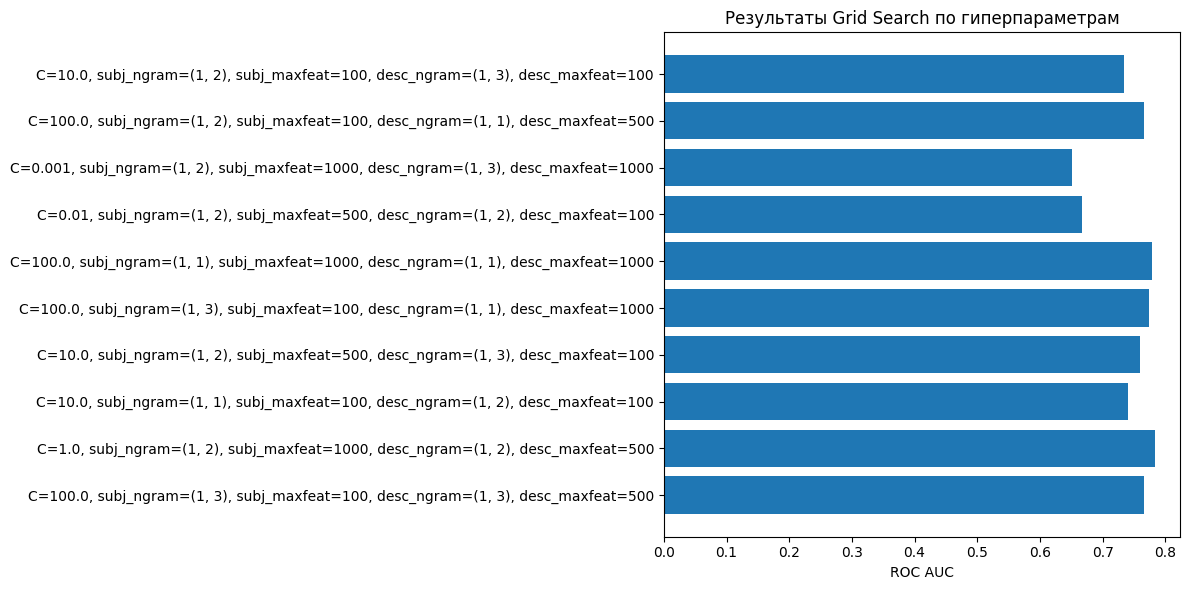

2025-02-24 18:30:45,334 - INFO - Анализ результатов на отложенной выборке...



Тексты с высокой уверенностью, но неверной классификацией (первые 20 строк):


100%|██████████| 20/20 [00:00<00:00, 20078.05it/s]


Subject: СРОЧНО ДИПЛОМЫ ГОРЯТ
Description: Добрый день. У всех группы не сформировываются вкладки дипломов. Для примера создала одну - 000167453
 
-- 
С уважением,
Манукян Джульетта Альбертовна
Факультет Финансов и банковского дела
Отделение магистратуры
 
Predicted: itsm_request True: itsm_incident Proba: 0.9258733614803913
--------------------------------------------------------------------------------
Subject: не работает КАС
Description: Добрый день, уважаемые коллеги!
У меня работает КАС. Заставка висит и дальше не загружается.

Прошу восстановить в кратчайшие сроки.
 
-- 
С УВАЖЕНИЕМ,
 
ЕРОФЕЕВА ТАТЬЯНА ВАСИЛЬЕВНА,
ВЕДУЩИЙ СПЕЦИАЛИСТ
"УЧЕБНОГО ЦЕНТРА" ФУНКЦИОНАЛЬНОГО БЛОКА 
"ВЫСШЕЕ ОБРАЗОВАНИЕ"
ПРЕЗИДЕНТСКАЯ АКАДЕМИЯ 

 
Predicted: itsm_request True: itsm_incident Proba: 0.9219637385183552
--------------------------------------------------------------------------------
Subject: провести приказ
Description: Прошу провести приказ №140162, 140088
 
 
 
 
-- 
_С уважением,_
_Гуляева 

100%|██████████| 20/20 [00:00<00:00, 19413.58it/s]
2025-02-24 18:30:45,352 - INFO - Построение графика распределения вероятностей...
2025-02-24 18:30:45,353 - INFO - Порог для 100% точности (класс 1): 1.00


Subject: !Демография/Синхронизация заявки
Description: Коллеги, доброе утро! На РвР приказ на отчисление внесли 04.07.2024 (слушатель Барышевская Юлия Сергеевна) (на РВР статус услуга прекращена), но в КАС информация не синхронизировалась, статус у слушателя VOCATIONTRAINING.
Шохзамон Шухратович сказал обычно синхронизация проходит в течение суток. Но уже проша почти неделя, а заявка не синхронизировалась.
 
- 
 

 
_ПЕТРОВА ИРИНА ВАДИМОВНА_
тел.:8 924 925 00 49

 
Predicted: itsm_request True: itsm_request Proba: 0.5970221408912418
--------------------------------------------------------------------------------
Subject: не могу подать заявление на доступ к курсу обучения
Description: Добрый день, коллеги!
 
Нет возможности пройти обучение, так как подача заявки выдает ошибку. Скрин прилагаю
 
 
-- 
С уважением, Елена Кирпенко
Тел: 88123359475 Внутр. 1532

Predicted: itsm_request True: itsm_request Proba: 0.5533335438131395
--------------------------------------------------------------

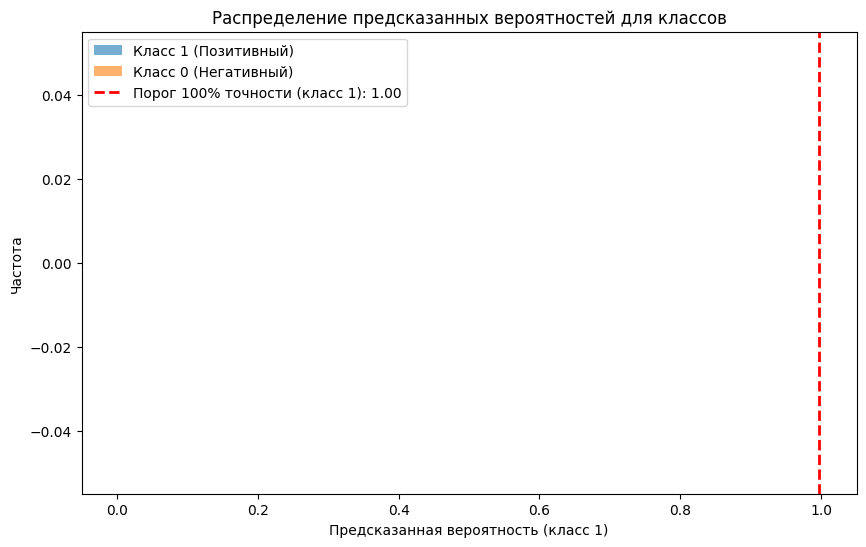

In [1]:
import logging
import os
import re

import joblib
import nltk
import pandas as pd

nltk.download("stopwords")
from nltk.corpus import stopwords

russian_stopwords = stopwords.words("russian")

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import FunctionTransformer

# Настройка логирования
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)
logger = logging.getLogger(__name__)


# Определяем именованные функции для выбора колонок (они будут picklable)
def select_subject(X):
    return X["subject"]


def select_description(X):
    return X["description"]


# ========================
# Трансформер для извлечения экстра признаков из одной текстовой колонки
# (например, для subject или description)
# ========================
class ExtraTextFeaturesSingle(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        features = []
        # X ожидается как последовательность строк (Series)
        for text in X:
            text = text if isinstance(text, str) else ""
            word_count = len(text.split())
            char_count = len(text)
            url_present = 1 if re.search(r"http[s]?://", text) else 0
            features.append([word_count, char_count, url_present])
        return np.array(features)


# ========================
# Пайплайны для текстовых признаков с TF-IDF с ограничением по количеству фичей
# ========================
subject_tfidf_pipeline = Pipeline(
    [
        ("selector", FunctionTransformer(select_subject, validate=False)),
        (
            "tfidf",
            TfidfVectorizer(
                stop_words=russian_stopwords, lowercase=True, max_features=500
            ),
        ),
    ]
)

desc_tfidf_pipeline = Pipeline(
    [
        ("selector", FunctionTransformer(select_description, validate=False)),
        (
            "tfidf",
            TfidfVectorizer(
                stop_words=russian_stopwords, lowercase=True, max_features=500
            ),
        ),
    ]
)

# ========================
# Пайплайны для экстра признаков по отдельности
# ========================
subject_extra_pipeline = Pipeline(
    [
        ("selector", FunctionTransformer(select_subject, validate=False)),
        ("extra", ExtraTextFeaturesSingle()),
    ]
)

desc_extra_pipeline = Pipeline(
    [
        ("selector", FunctionTransformer(select_description, validate=False)),
        ("extra", ExtraTextFeaturesSingle()),
    ]
)

# Объединяем все признаки
features_union = FeatureUnion(
    [
        ("subject_tfidf", subject_tfidf_pipeline),
        ("desc_tfidf", desc_tfidf_pipeline),
        ("subject_extra", subject_extra_pipeline),
        ("desc_extra", desc_extra_pipeline),
    ]
)

# ========================
# Полный пайплайн: признаки + классификатор
# ========================
pipeline = Pipeline(
    [("features", features_union), ("clf", LogisticRegression(solver="liblinear"))]
)

# ========================
# Расширенный набор гиперпараметров для RandomizedSearchCV
# ========================
param_grid = {
    "clf__C": [0.001, 0.01, 0.1, 1, 10, 100],
    "clf__penalty": ["l1", "l2"],
    "features__subject_tfidf__tfidf__ngram_range": [(1, 1), (1, 2), (1, 3)],
    "features__subject_tfidf__tfidf__max_features": [100, 500, 1000],
    "features__desc_tfidf__tfidf__ngram_range": [(1, 1), (1, 2), (1, 3)],
    "features__desc_tfidf__tfidf__max_features": [100, 500, 1000],
}

# ========================
# Загрузка и подготовка данных
# Предполагается, что данные содержатся в CSV-файле с колонками: 'subject', 'description', 'class'
# ========================
logger.info("Загрузка данных...")
data = pd.read_csv("../data/df.csv")  # замените путь к данным при необходимости

# Заполнение пустых значений специальными значениями
data["subject"] = data["subject"].fillna("no_subject")
data["description"] = data["description"].fillna("no_description")

X = data[["subject", "description"]]
y = data["class"]  # классы должны быть бинарными (например, 0 и 1)

# Разбивка на обучающую и отложенную выборки
logger.info("Разбивка данных на train и test...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ========================
# Поиск лучших гиперпараметров с помощью RandomizedSearchCV
# ========================
logger.info("Запуск RandomizedSearchCV...")
grid = RandomizedSearchCV(
    pipeline, param_grid, cv=5, scoring="roc_auc", n_jobs=10, verbose=1, n_iter=10
)
grid.fit(X_train, y_train)
logger.info("RandomizedSearchCV завершён.")
logger.info(f"Лучшие гиперпараметры: {grid.best_params_}")

# ========================
# Сохранение обученной модели в директорию "models"
# ========================
os.makedirs("../models", exist_ok=True)
model_path = os.path.join("../models", "best_model.pkl")
joblib.dump(grid.best_estimator_, model_path)
logger.info(f"Модель сохранена по пути: {model_path}")

# ========================
# Загрузка модели из файла и оценка на тестовой выборке
# ========================
loaded_model = joblib.load(model_path)
logger.info("Модель загружена для дальнейшей оценки.")

y_pred = loaded_model.predict(X_test)
y_proba = loaded_model.predict_proba(X_test)[:, 1]

logger.info("Отчёт по классификации:")
print(classification_report(y_test, y_pred))
roc_auc = roc_auc_score(y_test, y_proba)
logger.info(f"ROC AUC: {roc_auc}")

# ========================
# Визуализация результатов RandomizedSearchCV
# ========================
results = pd.DataFrame(grid.cv_results_)
results["params_str"] = results.apply(
    lambda row: f"C={row['param_clf__C']}, subj_ngram={row['param_features__subject_tfidf__tfidf__ngram_range']}, subj_maxfeat={row['param_features__subject_tfidf__tfidf__max_features']}, desc_ngram={row['param_features__desc_tfidf__tfidf__ngram_range']}, desc_maxfeat={row['param_features__desc_tfidf__tfidf__max_features']}",
    axis=1,
)

plt.figure(figsize=(12, 6))
plt.barh(results["params_str"], results["mean_test_score"])
plt.xlabel("ROC AUC")
plt.title("Результаты Grid Search по гиперпараметрам")
plt.tight_layout()
plt.show()

# ========================
# Анализ текстов на отложенной выборке (OOT)
# 2.4.1) Тексты с высокой уверенностью (вероятность > 0.9), но неверной классификацией
# 2.4.2) Тексты с низкой уверенностью (вероятность около 0.5), но с верным предсказанием
# ========================
logger.info("Анализ результатов на отложенной выборке...")

# Объединяем данные для удобства анализа
X_test_copy = X_test.copy()
X_test_copy["y_true"] = y_test.values
X_test_copy["y_pred"] = y_pred
X_test_copy["proba"] = y_proba

# Создаем директорию для результатов
os.makedirs("../results", exist_ok=True)

# Высокая уверенность, но неверная классификация
high_conf_wrong = X_test_copy[
    (X_test_copy["proba"] > 0.9) & (X_test_copy["y_pred"] != X_test_copy["y_true"])
]
# Сохраняем полный результат в CSV
high_conf_wrong.to_csv(os.path.join("../results", "high_conf_wrong.csv"), index=False)
print("\nТексты с высокой уверенностью, но неверной классификацией (первые 20 строк):")
for idx, row in tqdm(
    high_conf_wrong.head(20).iterrows(), total=min(20, len(high_conf_wrong))
):
    print("Subject:", row["subject"])
    print("Description:", row["description"])
    print("Predicted:", row["y_pred"], "True:", row["y_true"], "Proba:", row["proba"])
    print("-" * 80)

# Низкая уверенность, но верная классификация
low_conf_correct = X_test_copy[
    (abs(X_test_copy["proba"] - 0.5) < 0.1)
    & (X_test_copy["y_pred"] == X_test_copy["y_true"])
]
# Сохраняем полный результат в CSV
low_conf_correct.to_csv(os.path.join("../results", "low_conf_correct.csv"), index=False)
print("\nТексты с низкой уверенностью, но верной классификацией (первые 20 строк):")
for idx, row in tqdm(
    low_conf_correct.head(20).iterrows(), total=min(20, len(low_conf_correct))
):
    print("Subject:", row["subject"])
    print("Description:", row["description"])
    print("Predicted:", row["y_pred"], "True:", row["y_true"], "Proba:", row["proba"])
    print("-" * 80)

# ========================
# Построение графика распределения вероятностей и порог 100% точности для класса 1
# ========================
logger.info("Построение графика распределения вероятностей...")

# Вычисляем порог для 100% точности по классу 1:
threshold_100 = None
for thresh in np.sort(np.unique(y_proba))[::-1]:
    y_pred_thresh = (y_proba >= thresh).astype(int)
    if y_pred_thresh.sum() == 0:
        continue
    fp = ((y_test.values == 0) & (y_pred_thresh == 1)).sum()
    if fp == 0:
        threshold_100 = thresh
        break

if threshold_100 is None:
    logger.warning(
        "Не удалось найти порог с 100% точностью для класса 1, используем минимальное значение."
    )
    threshold_100 = np.min(y_proba)

logger.info(f"Порог для 100% точности (класс 1): {threshold_100:.2f}")

plt.figure(figsize=(10, 6))
plt.hist(y_proba[y_test == 1], bins=50, alpha=0.6, label="Класс 1 (Позитивный)")
plt.hist(y_proba[y_test == 0], bins=50, alpha=0.6, label="Класс 0 (Негативный)")
plt.axvline(
    x=threshold_100,
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Порог 100% точности (класс 1): {threshold_100:.2f}",
)
plt.xlabel("Предсказанная вероятность (класс 1)")
plt.ylabel("Частота")
plt.title("Распределение предсказанных вероятностей для классов")
plt.legend()
plt.show()


<Axes: xlabel='proba', ylabel='Count'>

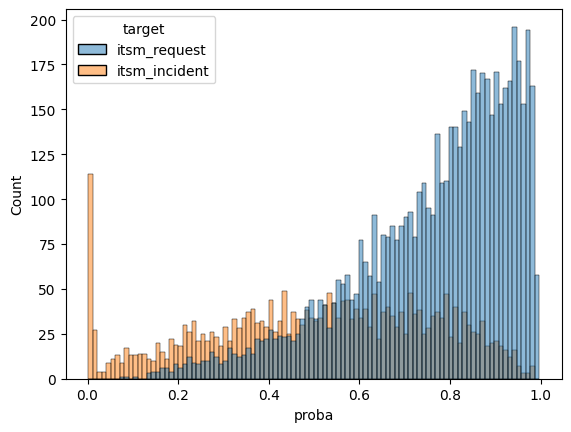

In [40]:
sns.histplot(df_test, x="proba", hue="target", bins=100)

[nltk_data] Downloading package stopwords to /home/vadim/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
2025-02-24 18:59:41,704 - INFO - Загрузка данных...
2025-02-24 18:59:41,953 - INFO - Разбивка данных на train и test...
2025-02-24 18:59:41,966 - INFO - Запуск RandomizedSearchCV...


Fitting 5 folds for each of 100 candidates, totalling 500 fits


/media/admin01/storage4/vadim/request_classifier/.venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/media/admin01/storage4/vadim/request_classifier/.venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/media/admin01/storage4/vadim/request_classifier/.venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the cu

               precision    recall  f1-score   support

itsm_incident       0.69      0.48      0.56      2737
 itsm_request       0.79      0.90      0.84      5901

     accuracy                           0.77      8638
    macro avg       0.74      0.69      0.70      8638
 weighted avg       0.76      0.77      0.75      8638


Тексты с высокой уверенностью, но неверной классификацией (первые 20 строк):


100%|██████████| 91/91 [00:00<00:00, 23128.02it/s]


Subject: СРОЧНО ДИПЛОМЫ ГОРЯТ
Description: Добрый день. У всех группы не сформировываются вкладки дипломов. Для примера создала одну - 000167453
 
-- 
С уважением,
Манукян Джульетта Альбертовна
Факультет Финансов и банковского дела
Отделение магистратуры
 
Predicted: itsm_request True: itsm_incident Proba: 0.9060930427233743
--------------------------------------------------------------------------------
Subject: Заявка на обучение Одинцов
Description: ________________________________
От: Иванова Яна Андреевна
Отправлено: 14 апреля 2024 г. 18:45:17
Кому: crr-hspa@ranepa.ru
Тема: Заявка на обучение Одинцов

Добрый день! Подали заявку на обучение с 17 апреля № 000279161 на Одинцова Р.В. - первого заместителя Главы города Красноярска. Вернули заявку, т.к. не хватало 2ой страницы паспорта с пропиской. Фото добавили, а заявку повторно сайт не пропускает.. подскажите, пожалуйста, как повторно направить? Анкета полностью заполнена.


С уважением,

Иванова Яна Андреевна,
помощник первого замес

100%|██████████| 20/20 [00:00<00:00, 17328.25it/s]
2025-02-24 19:03:25,133 - INFO - Построение графика распределения вероятностей...
2025-02-24 19:03:25,134 - INFO - Порог для 100% точности (класс 1): 1.00


Subject: КАС
Description: Добрый день! Не могу записать приказ на академический отпуск. На любой стадии выдает ошибку. Все данные введены верно. Прошу исправить
Predicted: itsm_incident True: itsm_incident Proba: 0.4806542619649017
--------------------------------------------------------------------------------
Subject: не проводится приказ 
Description: не проводится приказ, приказ в пдф подписанный прилагаю 
Приказ об отичслении 00142964
Predicted: itsm_incident True: itsm_incident Proba: 0.48149277806092533
--------------------------------------------------------------------------------
Subject: Проблема.
Description: Добрый день. У меня следующая проблема: чудесным образом в 1С Корп. Центральная бухгалтерия произошло следующее: В заявке на кассовый расход 0000-38064  от 19.07.2024 Вместо Ставропольского филиала в поле получатель платежа стал ОПТБ6 ООО. Автором изменений фигурирует моя фамилия. В части смены наименования контрагента мною изменения не были сделаны. Помогите разобрать

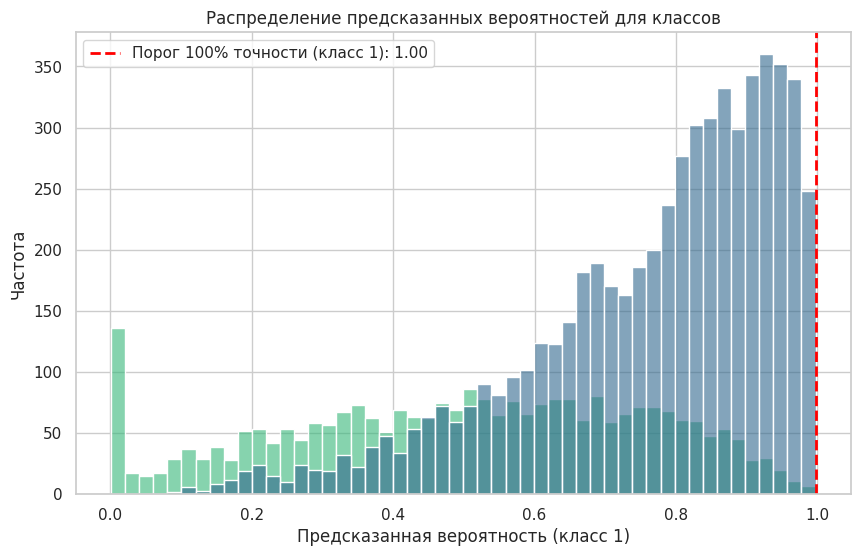

In [43]:
import logging
import os
import re

import joblib
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

nltk.download("stopwords")
from nltk.corpus import stopwords

russian_stopwords = stopwords.words("russian")

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import FunctionTransformer

# Настройка логирования
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)
logger = logging.getLogger(__name__)

# Настройка стиля seaborn
sns.set(style="whitegrid")


# Определяем именованные функции для выбора колонок
def select_subject(X):
    return X["subject"]


def select_description(X):
    return X["description"]


# ========================
# Трансформер для извлечения экстра признаков из одной текстовой колонки
# ========================
class ExtraTextFeaturesSingle(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        features = []
        for text in X:
            text = text if isinstance(text, str) else ""
            word_count = len(text.split())
            char_count = len(text)
            url_present = 1 if re.search(r"http[s]?://", text) else 0
            features.append([word_count, char_count, url_present])
        return np.array(features)


# ========================
# Пайплайны для текстовых признаков с TF-IDF
# ========================
subject_tfidf_pipeline = Pipeline(
    [
        ("selector", FunctionTransformer(select_subject, validate=False)),
        (
            "tfidf",
            TfidfVectorizer(
                stop_words=russian_stopwords, lowercase=True, max_features=500
            ),
        ),
    ]
)

desc_tfidf_pipeline = Pipeline(
    [
        ("selector", FunctionTransformer(select_description, validate=False)),
        (
            "tfidf",
            TfidfVectorizer(
                stop_words=russian_stopwords, lowercase=True, max_features=500
            ),
        ),
    ]
)

# ========================
# Пайплайны для экстра признаков по отдельности
# ========================
subject_extra_pipeline = Pipeline(
    [
        ("selector", FunctionTransformer(select_subject, validate=False)),
        ("extra", ExtraTextFeaturesSingle()),
    ]
)

desc_extra_pipeline = Pipeline(
    [
        ("selector", FunctionTransformer(select_description, validate=False)),
        ("extra", ExtraTextFeaturesSingle()),
    ]
)

# Объединяем все признаки
features_union = FeatureUnion(
    [
        ("subject_tfidf", subject_tfidf_pipeline),
        ("desc_tfidf", desc_tfidf_pipeline),
        ("subject_extra", subject_extra_pipeline),
        ("desc_extra", desc_extra_pipeline),
    ]
)

# ========================
# Полный пайплайн: признаки + классификатор
# ========================
pipeline = Pipeline(
    [("features", features_union), ("clf", LogisticRegression(solver="liblinear"))]
)

# ========================
# Расширенный набор гиперпараметров для RandomizedSearchCV
# ========================
param_grid = {
    "clf__C": [0.001, 0.01, 0.1, 1, 10, 100],
    "clf__penalty": ["l1", "l2"],
    "features__subject_tfidf__tfidf__ngram_range": [(1, 1), (1, 2), (1, 3)],
    "features__subject_tfidf__tfidf__max_features": [100, 500, 1000],
    "features__desc_tfidf__tfidf__ngram_range": [(1, 1), (1, 2), (1, 3)],
    "features__desc_tfidf__tfidf__max_features": [100, 500, 1000],
}

# ========================
# Загрузка и подготовка данных
# ========================
logger.info("Загрузка данных...")
data = pd.read_csv("../data/df.csv")  # замените путь к данным при необходимости

data["subject"] = data["subject"].fillna("no_subject")
data["description"] = data["description"].fillna("no_description")

X = data[["subject", "description"]]
y = data["class"]

logger.info("Разбивка данных на train и test...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ========================
# Поиск лучших гиперпараметров с помощью RandomizedSearchCV
# ========================
logger.info("Запуск RandomizedSearchCV...")
grid = RandomizedSearchCV(
    pipeline, param_grid, cv=5, scoring="roc_auc", n_jobs=10, verbose=1, n_iter=100
)
grid.fit(X_train, y_train)
logger.info("RandomizedSearchCV завершён.")
logger.info(f"Лучшие гиперпараметры: {grid.best_params_}")

# ========================
# Сохранение обученной модели в директорию "models"
# ========================
os.makedirs("../models", exist_ok=True)
model_path = os.path.join("../models", "best_model.pkl")
joblib.dump(grid.best_estimator_, model_path)
logger.info(f"Модель сохранена по пути: {model_path}")

# ========================
# Загрузка модели и оценка на тестовой выборке
# ========================
loaded_model = joblib.load(model_path)
logger.info("Модель загружена для дальнейшей оценки.")

y_pred = loaded_model.predict(X_test)
y_proba = loaded_model.predict_proba(X_test)[:, 1]

logger.info("Отчёт по классификации:")
print(classification_report(y_test, y_pred))
roc_auc = roc_auc_score(y_test, y_proba)
logger.info(f"ROC AUC: {roc_auc}")

# ========================
# Анализ текстов на отложенной выборке (OOT)
# ========================
logger.info("Анализ результатов на отложенной выборке...")

X_test_copy = X_test.copy()
X_test_copy["y_true"] = y_test.values
X_test_copy["y_pred"] = y_pred
X_test_copy["proba"] = y_proba

os.makedirs("../results", exist_ok=True)

high_conf_wrong = X_test_copy[
    (X_test_copy["proba"] > 0.9) & (X_test_copy["y_pred"] != X_test_copy["y_true"])
]
high_conf_wrong.to_csv(os.path.join("../results", "high_conf_wrong.csv"), index=False)
print("\nТексты с высокой уверенностью, но неверной классификацией (первые 20 строк):")
for idx, row in tqdm(high_conf_wrong.iterrows(), total=len(high_conf_wrong)):
    print("Subject:", row["subject"])
    print("Description:", row["description"])
    print("Predicted:", row["y_pred"], "True:", row["y_true"], "Proba:", row["proba"])
    print("-" * 80)

low_conf_correct = X_test_copy[
    (abs(X_test_copy["proba"] - 0.5) < 0.1)
    & (X_test_copy["y_pred"] == X_test_copy["y_true"])
]
low_conf_correct.to_csv(os.path.join("../results", "low_conf_correct.csv"), index=False)
print("\nТексты с низкой уверенностью, но верной классификацией (первые 20 строк):")
for idx, row in tqdm(
    low_conf_correct.head(20).iterrows(), total=min(20, len(low_conf_correct))
):
    print("Subject:", row["subject"])
    print("Description:", row["description"])
    print("Predicted:", row["y_pred"], "True:", row["y_true"], "Proba:", row["proba"])
    print("-" * 80)

# ========================
# Построение графика распределения вероятностей с использованием seaborn
# ========================
logger.info("Построение графика распределения вероятностей...")

# Вычисляем порог для 100% точности по классу 1
threshold_100 = None
for thresh in np.sort(np.unique(y_proba))[::-1]:
    y_pred_thresh = (y_proba >= thresh).astype(int)
    if y_pred_thresh.sum() == 0:
        continue
    fp = ((y_test.values == 0) & (y_pred_thresh == 1)).sum()
    if fp == 0:
        threshold_100 = thresh
        break
if threshold_100 is None:
    logger.warning(
        "Не удалось найти порог с 100% точностью для класса 1, используем минимальное значение."
    )
    threshold_100 = np.min(y_proba)
logger.info(f"Порог для 100% точности (класс 1): {threshold_100:.2f}")

# Создаем DataFrame для графика
df_prob = pd.DataFrame({"proba": y_proba, "target": y_test.values})

plt.figure(figsize=(10, 6))
sns.histplot(
    data=df_prob, x="proba", hue="target", bins=50, alpha=0.6, palette="viridis"
)
plt.axvline(
    x=threshold_100,
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Порог 100% точности (класс 1): {threshold_100:.2f}",
)
plt.xlabel("Предсказанная вероятность (класс 1)")
plt.ylabel("Частота")
plt.title("Распределение предсказанных вероятностей для классов")
plt.legend()
plt.show()


[nltk_data] Downloading package stopwords to /home/vadim/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
2025-02-24 19:09:54,473 - INFO - Загрузка данных...
2025-02-24 19:09:54,724 - INFO - Разбивка данных на train и test...
2025-02-24 19:09:54,730 - INFO - Запуск RandomizedSearchCV...


Fitting 5 folds for each of 100 candidates, totalling 500 fits


/media/admin01/storage4/vadim/request_classifier/.venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/media/admin01/storage4/vadim/request_classifier/.venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/media/admin01/storage4/vadim/request_classifier/.venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the cu

               precision    recall  f1-score   support

itsm_incident       0.66      0.37      0.47      2737
 itsm_request       0.76      0.91      0.83      5901

     accuracy                           0.74      8638
    macro avg       0.71      0.64      0.65      8638
 weighted avg       0.73      0.74      0.72      8638


Тексты с высокой уверенностью, но неверной классификацией (первые 20 строк):


100%|██████████| 38/38 [00:00<00:00, 18153.02it/s]


Subject: МФЦ. ВУС. Не работает подписание справок МФЦ
Description: Коллеги, добрый день!
 

Посмотрите, пожалуйста, почему в процессе отработки заявки "на подписание Справок ЭЦП" две заявки были взяты в работу, а делее процесс не пошёл.
Кнопка "Подписать справку ЭЦП" не активна.
Справки остались в разделе "Мои в работе".
Фамилии двух студентов, чьи справки программа не допустила к подписанию ЭЦП:

- ЧЕРГИК БОГДАН ВЛАДИМИРОВИЧ, 05.07.2000, 2 КУРС,
- ЗАБКОВ ВЯЧЕСЛАВ ВЛАДИМИРОВИЧ, 08.04.2006, 3 КУРС.
С уважением, Юсупов Р.Я.
 

-- С уважением,
Дашков Кирилл Валерьевич
 
Главный эксперт Дирекции по цифровому развитию
Российская академия народного хозяйства
и государственной службы при Президенте РФ
Тел. +7 499 956 01 80 (60180)
 
Predicted: itsm_request True: itsm_incident Proba: 0.9238373070008102
--------------------------------------------------------------------------------
Subject: Объединение личных кабинетов 
Description: Добрый день! 
Могу зайти в ЛК, чтобы объединить записи. 
Прош

100%|██████████| 20/20 [00:00<00:00, 13056.20it/s]
2025-02-24 19:10:24,395 - INFO - Построение графика распределения вероятностей...
2025-02-24 19:10:24,396 - INFO - Порог для 100% точности (класс 1): 0.98


Subject:  Проблема с учебным планом
Description: При создании аттестационных ведомостей на группы 0000869772 0000869773 0000869774 0000869775 система не дает выбирать предметы из учебного плана 000014008. Когда мы заходим внутрь учебного плана, система требует заполнить раздел "график сессии". Когда мы это делаем, система выдает ошибку со скриншота.
Predicted: itsm_request True: itsm_request Proba: 0.5170702637936581
--------------------------------------------------------------------------------
Subject: Не получается зайти в ЛК ранепу
Description: Добрый день.

Меня зовут Шлейгер Генрих Генрихович. Студент магистратуры, г. Саратов,
Филиал РАНХиГС, Поволжский институт управления имени П. А. Столыпина, 2
курс, группа 4202, направление 38.04.01.

Я не могу зайти в личный кабинет ранепы, чтобы пользоваться антиплагиатом.
Логин и пароль который был прислан на почту не работает.

Predicted: itsm_request True: itsm_request Proba: 0.5553804927563106
------------------------------------------

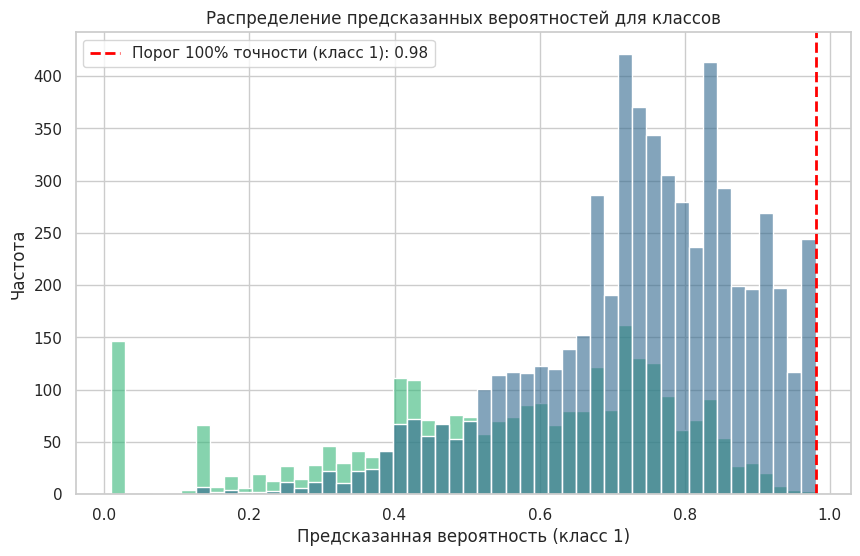

In [45]:
import logging
import os
import re

import joblib
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

nltk.download("stopwords")
from nltk.corpus import stopwords

russian_stopwords = stopwords.words("russian")

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import FunctionTransformer

# Настройка логирования
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)
logger = logging.getLogger(__name__)

# Настройка стиля seaborn
sns.set(style="whitegrid")


# Определяем именованные функции для выбора колонок
def select_subject(X):
    return X["subject"]


def select_description(X):
    return X["description"]


# ========================
# Трансформер для извлечения экстра признаков из одной текстовой колонки
# ========================
class ExtraTextFeaturesSingle(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        features = []
        for text in X:
            text = text if isinstance(text, str) else ""
            word_count = len(text.split())
            char_count = len(text)
            url_present = 1 if re.search(r"http[s]?://", text) else 0
            features.append([word_count, char_count, url_present])
        return np.array(features)


# ========================
# Пайплайны для текстовых признаков с TF-IDF
# ========================
subject_tfidf_pipeline = Pipeline(
    [
        ("selector", FunctionTransformer(select_subject, validate=False)),
        (
            "tfidf",
            TfidfVectorizer(
                stop_words=russian_stopwords, lowercase=True, max_features=500
            ),
        ),
    ]
)

desc_tfidf_pipeline = Pipeline(
    [
        ("selector", FunctionTransformer(select_description, validate=False)),
        (
            "tfidf",
            TfidfVectorizer(
                stop_words=russian_stopwords, lowercase=True, max_features=500
            ),
        ),
    ]
)

# ========================
# Пайплайны для экстра признаков по отдельности
# ========================
subject_extra_pipeline = Pipeline(
    [
        ("selector", FunctionTransformer(select_subject, validate=False)),
        ("extra", ExtraTextFeaturesSingle()),
    ]
)

desc_extra_pipeline = Pipeline(
    [
        ("selector", FunctionTransformer(select_description, validate=False)),
        ("extra", ExtraTextFeaturesSingle()),
    ]
)

# Объединяем все признаки
features_union = FeatureUnion(
    [
        ("subject_tfidf", subject_tfidf_pipeline),
        # ("desc_tfidf", desc_tfidf_pipeline),
        ("subject_extra", subject_extra_pipeline),
        # ("desc_extra", desc_extra_pipeline),
    ]
)

# ========================
# Полный пайплайн: признаки + классификатор
# ========================
pipeline = Pipeline(
    [("features", features_union), ("clf", LogisticRegression(solver="liblinear"))]
)

# ========================
# Расширенный набор гиперпараметров для RandomizedSearchCV
# ========================
param_grid = {
    "clf__C": [0.001, 0.01, 0.1, 1, 10, 100],
    "clf__penalty": ["l1", "l2"],
    "features__subject_tfidf__tfidf__ngram_range": [(1, 1), (1, 2), (1, 3)],
    "features__subject_tfidf__tfidf__max_features": [100, 500, 1000],
    # "features__desc_tfidf__tfidf__ngram_range": [(1, 1), (1, 2), (1, 3)],
    # "features__desc_tfidf__tfidf__max_features": [100, 500, 1000],
}

# ========================
# Загрузка и подготовка данных
# ========================
logger.info("Загрузка данных...")
data = pd.read_csv("../data/df.csv")  # замените путь к данным при необходимости

data["subject"] = data["subject"].fillna("no_subject")
data["description"] = data["description"].fillna("no_description")

X = data[["subject", "description"]]
y = data["class"]

logger.info("Разбивка данных на train и test...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ========================
# Поиск лучших гиперпараметров с помощью RandomizedSearchCV
# ========================
logger.info("Запуск RandomizedSearchCV...")
grid = RandomizedSearchCV(
    pipeline, param_grid, cv=5, scoring="roc_auc", n_jobs=10, verbose=1, n_iter=100
)
grid.fit(X_train, y_train)
logger.info("RandomizedSearchCV завершён.")
logger.info(f"Лучшие гиперпараметры: {grid.best_params_}")

# ========================
# Сохранение обученной модели в директорию "models"
# ========================
os.makedirs("../models", exist_ok=True)
model_path = os.path.join("../models", "best_model.pkl")
joblib.dump(grid.best_estimator_, model_path)
logger.info(f"Модель сохранена по пути: {model_path}")

# ========================
# Загрузка модели и оценка на тестовой выборке
# ========================
loaded_model = joblib.load(model_path)
logger.info("Модель загружена для дальнейшей оценки.")

y_pred = loaded_model.predict(X_test)
y_proba = loaded_model.predict_proba(X_test)[:, 1]

logger.info("Отчёт по классификации:")
print(classification_report(y_test, y_pred))
roc_auc = roc_auc_score(y_test, y_proba)
logger.info(f"ROC AUC: {roc_auc}")

# ========================
# Анализ текстов на отложенной выборке (OOT)
# ========================
logger.info("Анализ результатов на отложенной выборке...")

X_test_copy = X_test.copy()
X_test_copy["y_true"] = y_test.values
X_test_copy["y_pred"] = y_pred
X_test_copy["proba"] = y_proba

os.makedirs("../results", exist_ok=True)

high_conf_wrong = X_test_copy[
    (X_test_copy["proba"] > 0.9) & (X_test_copy["y_pred"] != X_test_copy["y_true"])
]
high_conf_wrong.to_csv(os.path.join("../results", "high_conf_wrong.csv"), index=False)
print("\nТексты с высокой уверенностью, но неверной классификацией (первые 20 строк):")
for idx, row in tqdm(high_conf_wrong.iterrows(), total=len(high_conf_wrong)):
    print("Subject:", row["subject"])
    print("Description:", row["description"])
    print("Predicted:", row["y_pred"], "True:", row["y_true"], "Proba:", row["proba"])
    print("-" * 80)

low_conf_correct = X_test_copy[
    (abs(X_test_copy["proba"] - 0.5) < 0.1)
    & (X_test_copy["y_pred"] == X_test_copy["y_true"])
]
low_conf_correct.to_csv(os.path.join("../results", "low_conf_correct.csv"), index=False)
print("\nТексты с низкой уверенностью, но верной классификацией (первые 20 строк):")
for idx, row in tqdm(
    low_conf_correct.head(20).iterrows(), total=min(20, len(low_conf_correct))
):
    print("Subject:", row["subject"])
    print("Description:", row["description"])
    print("Predicted:", row["y_pred"], "True:", row["y_true"], "Proba:", row["proba"])
    print("-" * 80)

# ========================
# Построение графика распределения вероятностей с использованием seaborn
# ========================
logger.info("Построение графика распределения вероятностей...")

# Вычисляем порог для 100% точности по классу 1
threshold_100 = None
for thresh in np.sort(np.unique(y_proba))[::-1]:
    y_pred_thresh = (y_proba >= thresh).astype(int)
    if y_pred_thresh.sum() == 0:
        continue
    fp = ((y_test.values == 0) & (y_pred_thresh == 1)).sum()
    if fp == 0:
        threshold_100 = thresh
        break
if threshold_100 is None:
    logger.warning(
        "Не удалось найти порог с 100% точностью для класса 1, используем минимальное значение."
    )
    threshold_100 = np.min(y_proba)
logger.info(f"Порог для 100% точности (класс 1): {threshold_100:.2f}")

# Создаем DataFrame для графика
df_prob = pd.DataFrame({"proba": y_proba, "target": y_test.values})

plt.figure(figsize=(10, 6))
sns.histplot(
    data=df_prob, x="proba", hue="target", bins=50, alpha=0.6, palette="viridis"
)
plt.axvline(
    x=threshold_100,
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Порог 100% точности (класс 1): {threshold_100:.2f}",
)
plt.xlabel("Предсказанная вероятность (класс 1)")
plt.ylabel("Частота")
plt.title("Распределение предсказанных вероятностей для классов")
plt.legend()
plt.show()

[nltk_data] Downloading package stopwords to /home/vadim/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
2025-02-24 19:10:24,536 - INFO - Загрузка данных...
2025-02-24 19:10:24,791 - INFO - Разбивка данных на train и test...
2025-02-24 19:10:24,803 - INFO - Запуск RandomizedSearchCV...


Fitting 5 folds for each of 100 candidates, totalling 500 fits


/media/admin01/storage4/vadim/request_classifier/.venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/media/admin01/storage4/vadim/request_classifier/.venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/media/admin01/storage4/vadim/request_classifier/.venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the cu

               precision    recall  f1-score   support

itsm_incident       0.67      0.42      0.52      2737
 itsm_request       0.77      0.90      0.83      5901

     accuracy                           0.75      8638
    macro avg       0.72      0.66      0.67      8638
 weighted avg       0.74      0.75      0.73      8638


Тексты с высокой уверенностью, но неверной классификацией (первые 20 строк):


100%|██████████| 81/81 [00:00<00:00, 22986.38it/s]


Subject: no_subject
Description: Добрый день!

Прошу вас отозвать мое заявление 000016185  (4236903442) с госуслуг. 
Predicted: itsm_request True: itsm_incident Proba: 0.9385291036787232
--------------------------------------------------------------------------------
Subject: не работает КАС
Description: Добрый день, уважаемые коллеги!
У меня работает КАС. Заставка висит и дальше не загружается.

Прошу восстановить в кратчайшие сроки.
 
-- 
С УВАЖЕНИЕМ,
 
ЕРОФЕЕВА ТАТЬЯНА ВАСИЛЬЕВНА,
ВЕДУЩИЙ СПЕЦИАЛИСТ
"УЧЕБНОГО ЦЕНТРА" ФУНКЦИОНАЛЬНОГО БЛОКА 
"ВЫСШЕЕ ОБРАЗОВАНИЕ"
ПРЕЗИДЕНТСКАЯ АКАДЕМИЯ 

 
Predicted: itsm_request True: itsm_incident Proba: 0.9798652305635899
--------------------------------------------------------------------------------
Subject: Ошибки при входе в личный кабинет
Description: 
--
С уважением, Марина!
Predicted: itsm_request True: itsm_incident Proba: 0.906463853647848
--------------------------------------------------------------------------------
Subject: Невозможност

100%|██████████| 20/20 [00:00<00:00, 18674.55it/s]
2025-02-24 19:13:28,166 - INFO - Построение графика распределения вероятностей...
2025-02-24 19:13:28,166 - INFO - Порог для 100% точности (класс 1): 1.00


Subject:  Проблема с учебным планом
Description: При создании аттестационных ведомостей на группы 0000869772 0000869773 0000869774 0000869775 система не дает выбирать предметы из учебного плана 000014008. Когда мы заходим внутрь учебного плана, система требует заполнить раздел "график сессии". Когда мы это делаем, система выдает ошибку со скриншота.
Predicted: itsm_request True: itsm_request Proba: 0.5386562720456254
--------------------------------------------------------------------------------
Subject: Новгородский филиал_Приказ о зачислении на магистратуру
Description: Добрый день! Не можем провести приказ о зачислении в ПК2024 под номером 00000875. Пишет ошибку - "Студент: Дороднов Егор Вадимович уже зачислялся в этом учебном году с таким статусом." Но данный студент изначально был зачислен на бакалавриат, затем в процессе обучения отчислился и подал документы на магистратуру, прошёл по конкурсу, теперь необходимо его зачислить!!! Срочно помогите решить проблему!!!
Predicted: itsm

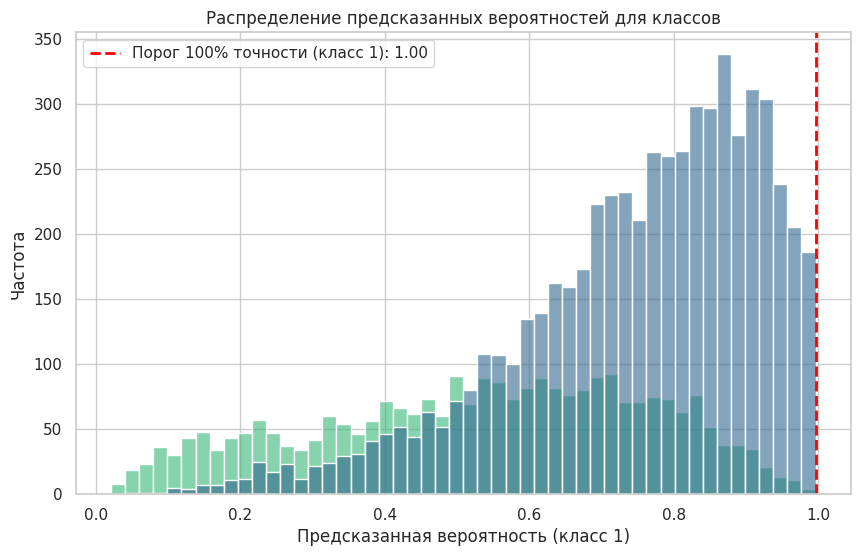

In [46]:
import logging
import os
import re

import joblib
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

nltk.download("stopwords")
from nltk.corpus import stopwords

russian_stopwords = stopwords.words("russian")

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import FunctionTransformer

# Настройка логирования
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)
logger = logging.getLogger(__name__)

# Настройка стиля seaborn
sns.set(style="whitegrid")


# Определяем именованные функции для выбора колонок
def select_subject(X):
    return X["subject"]


def select_description(X):
    return X["description"]


# ========================
# Трансформер для извлечения экстра признаков из одной текстовой колонки
# ========================
class ExtraTextFeaturesSingle(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        features = []
        for text in X:
            text = text if isinstance(text, str) else ""
            word_count = len(text.split())
            char_count = len(text)
            url_present = 1 if re.search(r"http[s]?://", text) else 0
            features.append([word_count, char_count, url_present])
        return np.array(features)


# ========================
# Пайплайны для текстовых признаков с TF-IDF
# ========================
subject_tfidf_pipeline = Pipeline(
    [
        ("selector", FunctionTransformer(select_subject, validate=False)),
        (
            "tfidf",
            TfidfVectorizer(
                stop_words=russian_stopwords, lowercase=True, max_features=500
            ),
        ),
    ]
)

desc_tfidf_pipeline = Pipeline(
    [
        ("selector", FunctionTransformer(select_description, validate=False)),
        (
            "tfidf",
            TfidfVectorizer(
                stop_words=russian_stopwords, lowercase=True, max_features=500
            ),
        ),
    ]
)

# ========================
# Пайплайны для экстра признаков по отдельности
# ========================
subject_extra_pipeline = Pipeline(
    [
        ("selector", FunctionTransformer(select_subject, validate=False)),
        ("extra", ExtraTextFeaturesSingle()),
    ]
)

desc_extra_pipeline = Pipeline(
    [
        ("selector", FunctionTransformer(select_description, validate=False)),
        ("extra", ExtraTextFeaturesSingle()),
    ]
)

# Объединяем все признаки
features_union = FeatureUnion(
    [
        # ("subject_tfidf", subject_tfidf_pipeline),
        ("desc_tfidf", desc_tfidf_pipeline),
        # ("subject_extra", subject_extra_pipeline),
        ("desc_extra", desc_extra_pipeline),
    ]
)

# ========================
# Полный пайплайн: признаки + классификатор
# ========================
pipeline = Pipeline(
    [("features", features_union), ("clf", LogisticRegression(solver="liblinear"))]
)

# ========================
# Расширенный набор гиперпараметров для RandomizedSearchCV
# ========================
param_grid = {
    "clf__C": [0.001, 0.01, 0.1, 1, 10, 100],
    "clf__penalty": ["l1", "l2"],
    # "features__subject_tfidf__tfidf__ngram_range": [(1, 1), (1, 2), (1, 3)],
    # "features__subject_tfidf__tfidf__max_features": [100, 500, 1000],
    "features__desc_tfidf__tfidf__ngram_range": [(1, 1), (1, 2), (1, 3)],
    "features__desc_tfidf__tfidf__max_features": [100, 500, 1000],
}

# ========================
# Загрузка и подготовка данных
# ========================
logger.info("Загрузка данных...")
data = pd.read_csv("../data/df.csv")  # замените путь к данным при необходимости

data["subject"] = data["subject"].fillna("no_subject")
data["description"] = data["description"].fillna("no_description")

X = data[["subject", "description"]]
y = data["class"]

logger.info("Разбивка данных на train и test...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ========================
# Поиск лучших гиперпараметров с помощью RandomizedSearchCV
# ========================
logger.info("Запуск RandomizedSearchCV...")
grid = RandomizedSearchCV(
    pipeline, param_grid, cv=5, scoring="roc_auc", n_jobs=10, verbose=1, n_iter=100
)
grid.fit(X_train, y_train)
logger.info("RandomizedSearchCV завершён.")
logger.info(f"Лучшие гиперпараметры: {grid.best_params_}")

# ========================
# Сохранение обученной модели в директорию "models"
# ========================
os.makedirs("../models", exist_ok=True)
model_path = os.path.join("../models", "best_model.pkl")
joblib.dump(grid.best_estimator_, model_path)
logger.info(f"Модель сохранена по пути: {model_path}")

# ========================
# Загрузка модели и оценка на тестовой выборке
# ========================
loaded_model = joblib.load(model_path)
logger.info("Модель загружена для дальнейшей оценки.")

y_pred = loaded_model.predict(X_test)
y_proba = loaded_model.predict_proba(X_test)[:, 1]

logger.info("Отчёт по классификации:")
print(classification_report(y_test, y_pred))
roc_auc = roc_auc_score(y_test, y_proba)
logger.info(f"ROC AUC: {roc_auc}")

# ========================
# Анализ текстов на отложенной выборке (OOT)
# ========================
logger.info("Анализ результатов на отложенной выборке...")

X_test_copy = X_test.copy()
X_test_copy["y_true"] = y_test.values
X_test_copy["y_pred"] = y_pred
X_test_copy["proba"] = y_proba

os.makedirs("../results", exist_ok=True)

high_conf_wrong = X_test_copy[
    (X_test_copy["proba"] > 0.9) & (X_test_copy["y_pred"] != X_test_copy["y_true"])
]
high_conf_wrong.to_csv(os.path.join("../results", "high_conf_wrong.csv"), index=False)
print("\nТексты с высокой уверенностью, но неверной классификацией (первые 20 строк):")
for idx, row in tqdm(high_conf_wrong.iterrows(), total=len(high_conf_wrong)):
    print("Subject:", row["subject"])
    print("Description:", row["description"])
    print("Predicted:", row["y_pred"], "True:", row["y_true"], "Proba:", row["proba"])
    print("-" * 80)

low_conf_correct = X_test_copy[
    (abs(X_test_copy["proba"] - 0.5) < 0.1)
    & (X_test_copy["y_pred"] == X_test_copy["y_true"])
]
low_conf_correct.to_csv(os.path.join("../results", "low_conf_correct.csv"), index=False)
print("\nТексты с низкой уверенностью, но верной классификацией (первые 20 строк):")
for idx, row in tqdm(
    low_conf_correct.head(20).iterrows(), total=min(20, len(low_conf_correct))
):
    print("Subject:", row["subject"])
    print("Description:", row["description"])
    print("Predicted:", row["y_pred"], "True:", row["y_true"], "Proba:", row["proba"])
    print("-" * 80)

# ========================
# Построение графика распределения вероятностей с использованием seaborn
# ========================
logger.info("Построение графика распределения вероятностей...")

# Вычисляем порог для 100% точности по классу 1
threshold_100 = None
for thresh in np.sort(np.unique(y_proba))[::-1]:
    y_pred_thresh = (y_proba >= thresh).astype(int)
    if y_pred_thresh.sum() == 0:
        continue
    fp = ((y_test.values == 0) & (y_pred_thresh == 1)).sum()
    if fp == 0:
        threshold_100 = thresh
        break
if threshold_100 is None:
    logger.warning(
        "Не удалось найти порог с 100% точностью для класса 1, используем минимальное значение."
    )
    threshold_100 = np.min(y_proba)
logger.info(f"Порог для 100% точности (класс 1): {threshold_100:.2f}")

# Создаем DataFrame для графика
df_prob = pd.DataFrame({"proba": y_proba, "target": y_test.values})

plt.figure(figsize=(10, 6))
sns.histplot(
    data=df_prob, x="proba", hue="target", bins=50, alpha=0.6, palette="viridis"
)
plt.axvline(
    x=threshold_100,
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Порог 100% точности (класс 1): {threshold_100:.2f}",
)
plt.xlabel("Предсказанная вероятность (класс 1)")
plt.ylabel("Частота")
plt.title("Распределение предсказанных вероятностей для классов")
plt.legend()
plt.show()

## С лемматизацией

In [15]:
import logging
import os
import re

import joblib
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

nltk.download("stopwords")
from nltk.corpus import stopwords

russian_stopwords = stopwords.words("russian")

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import FunctionTransformer

# Настройка логирования и стиля seaborn
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)
logger = logging.getLogger(__name__)
sns.set(style="whitegrid")


####################################
# Функции для выбора колонок
####################################
def select_subject(X):
    return X["subject"]


def select_description(X):
    return X["description"]


def select_subject_lemmatized(X):
    return X["subject_lemmatized"]


def select_description_lemmatized(X):
    return X["description_lemmatized"]


####################################
# Трансформер для лемматизации с использованием Mystem
####################################
class MystemPreprocessor(BaseEstimator, TransformerMixin):
    """
    Трансформер, который принимает DataFrame с колонками "subject" и "description"
    и добавляет две новые колонки: "subject_lemmatized" и "description_lemmatized",
    полученные с помощью Mystem.
    """

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        from pymystem3 import Mystem

        mystem = Mystem()  # создаём экземпляр локально
        X = X.copy()

        def lemmatize(text):
            if not isinstance(text, str):
                return ""
            # mystem.lemmatize возвращает список токенов, включая пробельные символы
            lemmas = mystem.lemmatize(text)
            # Убираем лишние пробелы и символы переноса строк
            return " ".join(token.strip() for token in lemmas if token.strip())

        X["subject_lemmatized"] = X["subject"].apply(lemmatize)
        X["description_lemmatized"] = X["description"].apply(lemmatize)
        return X


####################################
# Трансформер для извлечения дополнительных признаков
####################################
class ExtraTextFeaturesSingle(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        features = []
        for text in X:
            text = text if isinstance(text, str) else ""
            word_count = len(text.split())
            char_count = len(text)
            url_present = 1 if re.search(r"http[s]?://", text) else 0
            features.append([word_count, char_count, url_present])
        return np.array(features)


####################################
# Пайплайны для текстовых признаков с TF-IDF (используем лемматизированные поля)
####################################
subject_tfidf_pipeline = Pipeline(
    [
        ("selector", FunctionTransformer(select_subject_lemmatized, validate=False)),
        (
            "tfidf",
            TfidfVectorizer(
                stop_words=russian_stopwords, lowercase=True, max_features=500
            ),
        ),
    ]
)

desc_tfidf_pipeline = Pipeline(
    [
        (
            "selector",
            FunctionTransformer(select_description_lemmatized, validate=False),
        ),
        (
            "tfidf",
            TfidfVectorizer(
                stop_words=russian_stopwords, lowercase=True, max_features=500
            ),
        ),
    ]
)

# Пайплайны для дополнительных признаков на лемматизированном тексте
subject_extra_pipeline = Pipeline(
    [
        ("selector", FunctionTransformer(select_subject_lemmatized, validate=False)),
        ("extra", ExtraTextFeaturesSingle()),
    ]
)

desc_extra_pipeline = Pipeline(
    [
        (
            "selector",
            FunctionTransformer(select_description_lemmatized, validate=False),
        ),
        ("extra", ExtraTextFeaturesSingle()),
    ]
)

# Объединяем все признаки
features_union = FeatureUnion(
    [
        ("subject_tfidf", subject_tfidf_pipeline),
        ("desc_tfidf", desc_tfidf_pipeline),
        ("subject_extra", subject_extra_pipeline),
        ("desc_extra", desc_extra_pipeline),
    ]
)

# Полный пайплайн: признаки + классификатор
pipeline = Pipeline(
    [("features", features_union), ("clf", LogisticRegression(solver="liblinear"))]
)


####################################
# Гиперпараметры для RandomizedSearchCV (включая max_df и min_df для TF-IDF)
####################################
param_grid = {
    "clf__C": [0.001, 0.01, 0.1, 1, 10, 100],
    "clf__penalty": ["l1", "l2"],
    "features__subject_tfidf__tfidf__ngram_range": [(1, 1), (1, 2), (1, 3)],
    "features__subject_tfidf__tfidf__max_features": [100, 500, 1000],
    "features__subject_tfidf__tfidf__max_df": [0.8, 0.9, 1.0],
    "features__subject_tfidf__tfidf__min_df": [1, 2],
    "features__desc_tfidf__tfidf__ngram_range": [(1, 1), (1, 2), (1, 3)],
    "features__desc_tfidf__tfidf__max_features": [100, 500, 1000],
    "features__desc_tfidf__tfidf__max_df": [0.8, 0.9, 1.0],
    "features__desc_tfidf__tfidf__min_df": [1, 2],
}


####################################
# Загрузка и подготовка данных
####################################
logger.info("Загрузка данных...")
data = pd.read_csv("../data/df.csv")  # замените путь к данным при необходимости
data["subject"] = data["subject"].fillna("no_subject")
data["description"] = data["description"].fillna("no_description")

# Сначала применяем лемматизацию с помощью MystemPreprocessor
preprocessor = MystemPreprocessor()
data_lemmatized = preprocessor.fit_transform(data)

# Используем исходные и лемматизированные колонки (в дальнейшем пайплайн выбирает только лемматизированные)
X = data_lemmatized[
    ["subject", "description", "subject_lemmatized", "description_lemmatized"]
]
y = data_lemmatized["class"]  # y содержит имена классов

logger.info("Разбивка данных на train и test...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


####################################
# Поиск гиперпараметров, обучение и оценка модели
####################################
logger.info("Запуск RandomizedSearchCV...")
grid = RandomizedSearchCV(
    pipeline, param_grid, cv=5, scoring="roc_auc", n_jobs=10, verbose=1, n_iter=100
)
grid.fit(X_train, y_train)
logger.info("RandomizedSearchCV завершён.")
logger.info(f"Лучшие гиперпараметры: {grid.best_params_}")

os.makedirs("../models", exist_ok=True)
model_path = os.path.join("../models", "best_model.pkl")
joblib.dump(grid.best_estimator_, model_path)
logger.info(f"Модель сохранена по пути: {model_path}")

loaded_model = joblib.load(model_path)
logger.info("Модель загружена для дальнейшей оценки.")

probas = loaded_model.predict_proba(X_test)
y_pred = loaded_model.predict(X_test)
classes = loaded_model.named_steps["clf"].classes_
predicted_proba = np.where(y_pred == classes[0], probas[:, 0], probas[:, 1])

logger.info("Отчёт по классификации:")
print(classification_report(y_test, y_pred))
roc_auc = roc_auc_score(y_test, probas[:, 1])
logger.info(f"ROC AUC: {roc_auc}")

# Здесь можно добавить дальнейшую визуализацию и анализ misclassified наблюдений.


[nltk_data] Downloading package stopwords to /home/vadim/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
2025-02-24 20:21:01,204 - INFO - Загрузка данных...
2025-02-24 20:21:36,071 - INFO - Разбивка данных на train и test...
2025-02-24 20:21:36,077 - INFO - Запуск RandomizedSearchCV...


Fitting 5 folds for each of 100 candidates, totalling 500 fits


/media/admin01/storage4/vadim/request_classifier/.venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/media/admin01/storage4/vadim/request_classifier/.venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/media/admin01/storage4/vadim/request_classifier/.venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the cu

               precision    recall  f1-score   support

itsm_incident       0.68      0.49      0.57      2737
 itsm_request       0.79      0.89      0.84      5901

     accuracy                           0.76      8638
    macro avg       0.73      0.69      0.70      8638
 weighted avg       0.76      0.76      0.75      8638



In [21]:
y_proba = loaded_model.predict_proba(X_test)[:, 1]


/media/admin01/storage4/vadim/request_classifier/.venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


2025-02-24 20:26:34,951 - INFO - Анализ результатов на отложенной выборке...



Тексты с высокой уверенностью, но неверной классификацией (первые 20 строк):


100%|██████████| 20/20 [00:00<00:00, 19301.91it/s]


Subject: СРОЧНО ДИПЛОМЫ ГОРЯТ
Description: Добрый день. У всех группы не сформировываются вкладки дипломов. Для примера создала одну - 000167453
 
-- 
С уважением,
Манукян Джульетта Альбертовна
Факультет Финансов и банковского дела
Отделение магистратуры
 
Predicted: itsm_request True: itsm_incident Proba: 0.9005473824481738
--------------------------------------------------------------------------------
Subject: не работает КАС
Description: Добрый день, уважаемые коллеги!
У меня работает КАС. Заставка висит и дальше не загружается.

Прошу восстановить в кратчайшие сроки.
 
-- 
С УВАЖЕНИЕМ,
 
ЕРОФЕЕВА ТАТЬЯНА ВАСИЛЬЕВНА,
ВЕДУЩИЙ СПЕЦИАЛИСТ
"УЧЕБНОГО ЦЕНТРА" ФУНКЦИОНАЛЬНОГО БЛОКА 
"ВЫСШЕЕ ОБРАЗОВАНИЕ"
ПРЕЗИДЕНТСКАЯ АКАДЕМИЯ 

 
Predicted: itsm_request True: itsm_incident Proba: 0.9040453827931031
--------------------------------------------------------------------------------
Subject:  
Description: Мне необходимо провести приказ о прикреплении соискателя Ивановой Дарии Вячеславовны. Да

100%|██████████| 20/20 [00:00<00:00, 19239.93it/s]
2025-02-24 20:26:34,979 - INFO - Построение графика распределения вероятностей...
2025-02-24 20:26:34,998 - INFO - Порог для 100% точности (класс 1): 1.00


Subject: Проблема с подачей заявки на формирование договора
Description: После заполнения всех данных на подачу договора, выдает ошибку и просит
обратиться в поддержку

Predicted: itsm_incident True: itsm_incident Proba: 0.43240696573635645
--------------------------------------------------------------------------------
Subject: Не удается отправить заявку в ОАиОФ
Description: При отправке заявки в аудиторный фонд, показывает ошибку - Указанная дата больше границы доступности

скрин прикладываю
Predicted: itsm_request True: itsm_request Proba: 0.5362984209786701
--------------------------------------------------------------------------------
Subject: приемная комиссия / первоочередное право
Description: уточнение информации!!!

если абитуриент у которого папа участник СВО....выбираем:
тип права- дети лиц, указанных в пункте 2-4   правильно???
тип документа - слово справка...ввести не возможно...выбор тоже не выходит...неактивна


Predicted: itsm_request True: itsm_request Proba: 0.5506

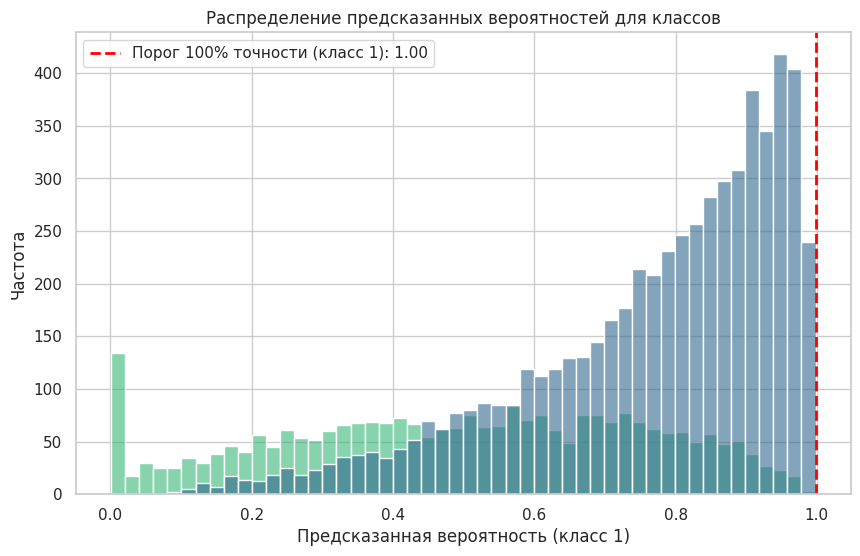

In [22]:
logger.info("Анализ результатов на отложенной выборке...")

X_test_copy = X_test.copy()
X_test_copy["y_true"] = y_test.values
X_test_copy["y_pred"] = y_pred
X_test_copy["proba"] = y_proba

os.makedirs("../results", exist_ok=True)

high_conf_wrong = X_test_copy[
    (X_test_copy["proba"] > 0.9) & (X_test_copy["y_pred"] != X_test_copy["y_true"])
]
high_conf_wrong.to_csv(os.path.join("../results", "high_conf_wrong.csv"), index=False)
print("\nТексты с высокой уверенностью, но неверной классификацией (первые 20 строк):")
for idx, row in tqdm(
    high_conf_wrong.head(20).iterrows(), total=len(high_conf_wrong.head(20))
):
    print("Subject:", row["subject"])
    print("Description:", row["description"])
    print("Predicted:", row["y_pred"], "True:", row["y_true"], "Proba:", row["proba"])
    print("-" * 80)

low_conf_correct = X_test_copy[
    (abs(X_test_copy["proba"] - 0.5) < 0.1)
    & (X_test_copy["y_pred"] == X_test_copy["y_true"])
]
low_conf_correct.to_csv(os.path.join("../results", "low_conf_correct.csv"), index=False)
print("\nТексты с низкой уверенностью, но верной классификацией (первые 20 строк):")
for idx, row in tqdm(
    low_conf_correct.head(20).iterrows(), total=min(20, len(low_conf_correct))
):
    print("Subject:", row["subject"])
    print("Description:", row["description"])
    print("Predicted:", row["y_pred"], "True:", row["y_true"], "Proba:", row["proba"])
    print("-" * 80)

# ========================
# Построение графика распределения вероятностей с использованием seaborn
# ========================
logger.info("Построение графика распределения вероятностей...")

# Вычисляем порог для 100% точности по классу 1
threshold_100 = None
for thresh in np.sort(np.unique(y_proba))[::-1]:
    y_pred_thresh = (y_proba >= thresh).astype(int)
    if y_pred_thresh.sum() == 0:
        continue
    fp = ((y_test.values == 0) & (y_pred_thresh == 1)).sum()
    if fp == 0:
        threshold_100 = thresh
        break
if threshold_100 is None:
    logger.warning(
        "Не удалось найти порог с 100% точностью для класса 1, используем минимальное значение."
    )
    threshold_100 = np.min(y_proba)
logger.info(f"Порог для 100% точности (класс 1): {threshold_100:.2f}")

# Создаем DataFrame для графика
df_prob = pd.DataFrame({"proba": y_proba, "target": y_test.values})

plt.figure(figsize=(10, 6))
sns.histplot(
    data=df_prob, x="proba", hue="target", bins=50, alpha=0.6, palette="viridis"
)
plt.axvline(
    x=threshold_100,
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Порог 100% точности (класс 1): {threshold_100:.2f}",
)
plt.xlabel("Предсказанная вероятность (класс 1)")
plt.ylabel("Частота")
plt.title("Распределение предсказанных вероятностей для классов")
plt.legend()
plt.show()

## Bert

In [2]:
import logging
import os
import re

import joblib
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from tqdm import tqdm
from transformers import AutoModel, AutoTokenizer

nltk.download("stopwords")
from nltk.corpus import stopwords

russian_stopwords = stopwords.words(
    "russian"
)  # можно использовать для дополнительных признаков

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import FunctionTransformer

# Настройка логирования и стиля графиков
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)
logger = logging.getLogger(__name__)
sns.set(style="whitegrid")


####################################
# Текстовый очиститель (удаляет URL, спецсимволы и лишние пробелы)
####################################
class TextCleanerTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        def clean_text(text):
            if not isinstance(text, str):
                return ""
            text = text.lower()
            # Удаляем URL
            text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)
            # Удаляем все, что не буквы или цифры
            text = re.sub(r"\W+", " ", text)
            text = re.sub(r"\s+", " ", text).strip()
            return text

        return X.apply(clean_text)


####################################
# Трансформер для извлечения эмбеддингов с использованием BERT (обработка батчами, max_length=512)
####################################
class BertVectorizer(BaseEstimator, TransformerMixin):
    def __init__(
        self,
        model_name="bert-base-multilingual-cased",
        max_length=512,
        batch_size=32,
        device=None,
    ):
        self.model_name = model_name
        self.max_length = max_length
        self.batch_size = batch_size
        self.device = (
            device
            if device is not None
            else ("cuda" if torch.cuda.is_available() else "cpu")
        )

    def fit(self, X, y=None):
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        self.model = AutoModel.from_pretrained(self.model_name)
        self.model.to(self.device)
        self.model.eval()
        return self

    def transform(self, X):
        texts = list(X)
        embeddings = []
        with torch.no_grad():
            for i in tqdm(range(0, len(texts), self.batch_size)):
                batch_texts = texts[i : i + self.batch_size]
                encoded = self.tokenizer(
                    batch_texts,
                    truncation=True,
                    max_length=self.max_length,
                    padding="max_length",
                    return_tensors="pt",
                )
                encoded = {k: v.to(self.device) for k, v in encoded.items()}
                output = self.model(**encoded)
                # Используем CLS-токен как представление
                batch_emb = output.last_hidden_state[:, 0, :].cpu().numpy()
                embeddings.append(batch_emb)
        return np.concatenate(embeddings, axis=0)


####################################
# Функции для выбора колонок
####################################
def select_subject(X):
    return X["subject"]


def select_description(X):
    return X["description"]


####################################
# Пайплайны для извлечения эмбеддингов из полей с очисткой текста и BERT
####################################
subject_bert_pipeline = Pipeline(
    [
        ("selector", FunctionTransformer(lambda X: X["subject"], validate=False)),
        ("cleaner", TextCleanerTransformer()),
        (
            "bert",
            BertVectorizer(
                model_name="bert-base-multilingual-cased", max_length=512, batch_size=32
            ),
        ),
    ]
)

desc_bert_pipeline = Pipeline(
    [
        ("selector", FunctionTransformer(lambda X: X["description"], validate=False)),
        ("cleaner", TextCleanerTransformer()),
        (
            "bert",
            BertVectorizer(
                model_name="bert-base-multilingual-cased", max_length=512, batch_size=32
            ),
        ),
    ]
)


####################################
# (Опционально) Трансформер для дополнительных признаков
####################################
class ExtraTextFeaturesSingle(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        feats = []
        for text in X:
            text = text if isinstance(text, str) else ""
            word_count = len(text.split())
            char_count = len(text)
            url_present = 1 if "http://" in text or "https://" in text else 0
            feats.append([word_count, char_count, url_present])
        return np.array(feats)


# Если нужны дополнительные признаки:
subject_extra_pipeline = Pipeline(
    [
        ("selector", FunctionTransformer(lambda X: X["subject"], validate=False)),
        ("extra", ExtraTextFeaturesSingle()),
    ]
)
desc_extra_pipeline = Pipeline(
    [
        ("selector", FunctionTransformer(lambda X: X["description"], validate=False)),
        ("extra", ExtraTextFeaturesSingle()),
    ]
)

# Объединяем эмбеддинги (и, при необходимости, дополнительные признаки)
features_union = FeatureUnion(
    [
        ("subject_bert", subject_bert_pipeline),
        ("desc_bert", desc_bert_pipeline),
        # ("subject_extra", subject_extra_pipeline),
        # ("desc_extra", desc_extra_pipeline)
    ]
)

####################################
# Пайплайн для классификации
####################################
# Обучение классификатора (например, LogisticRegression)
pipeline = Pipeline(
    [("features", features_union), ("clf", LogisticRegression(solver="liblinear"))]
)

####################################
# Обучение и подбор гиперпараметров классификатора на предвычисленных эмбеддингах
####################################
logger.info("Загрузка данных...")
data = pd.read_csv("../data/df.csv")  # замените путь к данным
data["subject"] = data["subject"].fillna("no_subject")
data["description"] = data["description"].fillna("no_description")
X = data[["subject", "description"]]
y = data["class"]

logger.info("Извлечение эмбеддингов для всего набора данных...")
# Извлекаем эмбеддинги для каждой колонки
subject_embeddings = subject_bert_pipeline.fit_transform(X)
desc_embeddings = desc_bert_pipeline.fit_transform(X)
# Объединяем эмбеддинги (конкатенация вдоль признакового измерения)
combined_embeddings = np.concatenate([subject_embeddings, desc_embeddings], axis=1)

logger.info("Разбивка данных на train и test...")
X_train_emb, X_test_emb, y_train, y_test = train_test_split(
    combined_embeddings, y, test_size=0.2, random_state=42
)

logger.info("Подбор гиперпараметров классификатора...")
param_grid = {"C": [0.001, 0.01, 0.1, 1, 10, 100], "penalty": ["l1", "l2"]}
grid_clf = RandomizedSearchCV(
    LogisticRegression(solver="lbfgs"),
    param_grid,
    cv=5,
    scoring="roc_auc",
    n_jobs=10,
    verbose=1,
    n_iter=10,
)
grid_clf.fit(X_train_emb, y_train)
logger.info(f"Лучшие гиперпараметры: {grid_clf.best_params_}")

y_pred = grid_clf.predict(X_test_emb)
probas = grid_clf.predict_proba(X_test_emb)
logger.info("Отчёт по классификации:")
print(classification_report(y_test, y_pred))
roc_auc = roc_auc_score(y_test, probas[:, 1])
logger.info(f"ROC AUC: {roc_auc}")

# ####################################
# # Сбор финального пайплайна
# ####################################
# # После подбора гиперпараметров, собираем финальный пайплайн, включающий шаги извлечения эмбеддингов и классификатор с оптимальными параметрами.
# final_pipeline = Pipeline(
#     [
#         ("features", features_union),
#         ("clf", LogisticRegression(solver="liblinear", **grid_clf.best_params_)),
#     ]
# )

# logger.info("Обучение финального пайплайна на всех данных...")
# final_pipeline.fit(X, y)

# os.makedirs("../models", exist_ok=True)
# final_model_path = os.path.join("../models", "final_pipeline.pkl")
# joblib.dump(final_pipeline, final_model_path)
# logger.info(f"Финальный пайплайн сохранён по пути: {final_model_path}")

# # На новых данных достаточно загрузить модель и вызвать predict/predict_proba:
# loaded_pipeline = joblib.load(final_model_path)
# new_data = pd.read_csv("../data/new_data.csv")  # замените путь к новым данным
# new_data["subject"] = new_data["subject"].fillna("no_subject")
# new_data["description"] = new_data["description"].fillna("no_description")
# predictions = loaded_pipeline.predict(new_data)
# pred_probas = loaded_pipeline.predict_proba(new_data)
# logger.info("Предсказания на новых данных:")
# print(predictions)


[nltk_data] Downloading package stopwords to /home/vadim/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
2025-02-24 21:22:11,117 - INFO - Загрузка данных...
2025-02-24 21:22:11,398 - INFO - Извлечение эмбеддингов для всего набора данных...
100%|██████████| 1350/1350 [04:48<00:00,  4.68it/s]
2025-02-24 21:31:48,487 - INFO - Разбивка данных на train и test...
2025-02-24 21:31:48,541 - INFO - Подбор гиперпараметров классификатора...


Fitting 5 folds for each of 10 candidates, totalling 50 fits


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

               precision    recall  f1-score   support

itsm_incident       0.65      0.44      0.53      2737
 itsm_request       0.77      0.89      0.83      5901

     accuracy                           0.75      8638
    macro avg       0.71      0.67      0.68      8638
 weighted avg       0.73      0.75      0.73      8638



2025-02-24 21:35:28,639 - INFO - Анализ результатов на отложенной выборке...
2025-02-24 21:35:28,639 - INFO - Построение графика распределения вероятностей...
2025-02-24 21:35:28,640 - INFO - Порог для 100% точности (класс 1): 1.00


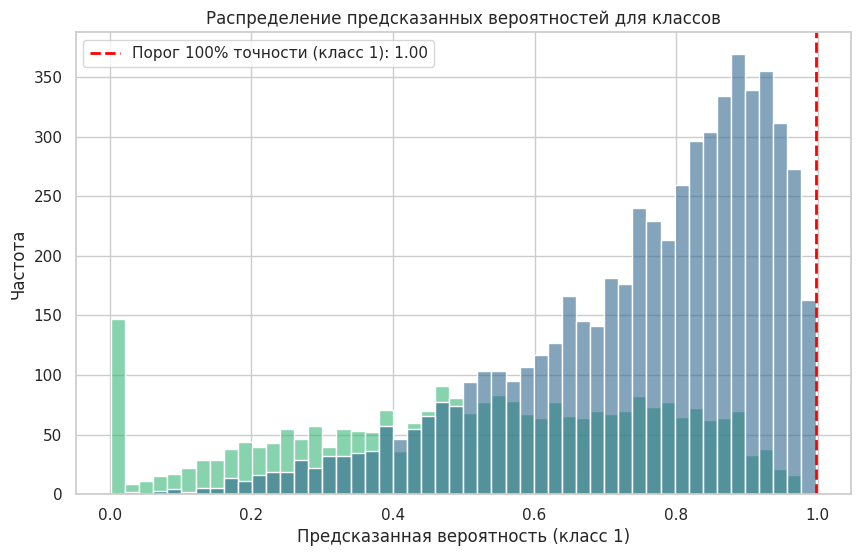

In [10]:
logger.info("Анализ результатов на отложенной выборке...")

y_proba = probas[:, 1]
# ========================
# Построение графика распределения вероятностей с использованием seaborn
# ========================
logger.info("Построение графика распределения вероятностей...")

# Вычисляем порог для 100% точности по классу 1
threshold_100 = None
for thresh in np.sort(np.unique(y_proba))[::-1]:
    y_pred_thresh = (y_proba >= thresh).astype(int)
    if y_pred_thresh.sum() == 0:
        continue
    fp = ((y_test.values == 0) & (y_pred_thresh == 1)).sum()
    if fp == 0:
        threshold_100 = thresh
        break
if threshold_100 is None:
    logger.warning(
        "Не удалось найти порог с 100% точностью для класса 1, используем минимальное значение."
    )
    threshold_100 = np.min(y_proba)
logger.info(f"Порог для 100% точности (класс 1): {threshold_100:.2f}")

# Создаем DataFrame для графика
df_prob = pd.DataFrame({"proba": y_proba, "target": y_test.values})

plt.figure(figsize=(10, 6))
sns.histplot(
    data=df_prob, x="proba", hue="target", bins=50, alpha=0.6, palette="viridis"
)
plt.axvline(
    x=threshold_100,
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Порог 100% точности (класс 1): {threshold_100:.2f}",
)
plt.xlabel("Предсказанная вероятность (класс 1)")
plt.ylabel("Частота")
plt.title("Распределение предсказанных вероятностей для классов")
plt.legend()
plt.show()

In [12]:
import logging
import os
import re

import joblib
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

nltk.download("stopwords")
from nltk.corpus import stopwords

russian_stopwords = stopwords.words(
    "russian"
)  # можно использовать для дополнительных признаков

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

# Настройка логирования и стиля графиков
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)
logger = logging.getLogger(__name__)
sns.set(style="whitegrid")


########################################
# Текстовый очиститель (удаляет URL, спецсимволы и лишние пробелы)
########################################
class TextCleanerTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        def clean_text(text):
            if not isinstance(text, str):
                return ""
            text = text.lower()
            # Удаляем URL
            text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)
            # Удаляем все, что не буквы или цифры
            text = re.sub(r"\W+", " ", text)
            text = re.sub(r"\s+", " ", text).strip()
            return text

        return X.apply(clean_text)


########################################
# Трансформер для получения эмбеддингов из текста с использованием BERT
# Обработка батчами, max_length=512
########################################
class BertVectorizer(BaseEstimator, TransformerMixin):
    def __init__(
        self,
        model_name="bert-base-multilingual-cased",
        max_length=512,
        batch_size=32,
        device=None,
    ):
        self.model_name = model_name
        self.max_length = max_length
        self.batch_size = batch_size
        self.device = (
            device
            if device is not None
            else ("cuda" if torch.cuda.is_available() else "cpu")
        )

    def fit(self, X, y=None):
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        self.model = AutoModel.from_pretrained(self.model_name)
        self.model.to(self.device)
        self.model.eval()
        return self

    def transform(self, X):
        texts = list(X)
        embeddings = []
        with torch.no_grad():
            for i in tqdm(range(0, len(texts), self.batch_size)):
                batch_texts = texts[i : i + self.batch_size]
                encoded = self.tokenizer(
                    batch_texts,
                    truncation=True,
                    max_length=self.max_length,
                    padding="max_length",
                    return_tensors="pt",
                )
                encoded = {k: v.to(self.device) for k, v in encoded.items()}
                output = self.model(**encoded)
                # CLS-токен как представление
                batch_emb = output.last_hidden_state[:, 0, :].cpu().numpy()
                embeddings.append(batch_emb)
        return np.concatenate(embeddings, axis=0)


########################################
# Функции для выбора колонок
########################################
def select_subject(X):
    return X["subject"]


def select_description(X):
    return X["description"]


########################################
# Пайплайны для получения эмбеддингов для каждого поля с очисткой
########################################
subject_bert_pipeline = Pipeline(
    [
        ("selector", FunctionTransformer(lambda X: X["subject"], validate=False)),
        ("cleaner", TextCleanerTransformer()),
        (
            "bert",
            BertVectorizer(
                model_name="bert-base-multilingual-cased", max_length=512, batch_size=32
            ),
        ),
    ]
)

desc_bert_pipeline = Pipeline(
    [
        ("selector", FunctionTransformer(lambda X: X["description"], validate=False)),
        ("cleaner", TextCleanerTransformer()),
        (
            "bert",
            BertVectorizer(
                model_name="bert-base-multilingual-cased", max_length=512, batch_size=32
            ),
        ),
    ]
)

########################################
# Загрузка и подготовка данных
########################################
logger.info("Загрузка данных...")
data = pd.read_csv("../data/df.csv")  # замените путь к вашим данным
data["subject"] = data["subject"].fillna("no_subject")
data["description"] = data["description"].fillna("no_description")

X = data[["subject", "description"]]
y = data["class"]  # y содержит имена классов

########################################
# Извлечение эмбеддингов отдельно для subject и description
########################################
logger.info("Извлечение эмбеддингов для поля subject...")
subject_embeddings = subject_bert_pipeline.fit_transform(X)
logger.info("Извлечение эмбеддингов для поля description...")
desc_embeddings = desc_bert_pipeline.fit_transform(X)

########################################
# Обучение модели только на эмбеддингах поля subject
########################################
logger.info("Обучение модели на эмбеддингах subject...")
X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(
    subject_embeddings, y, test_size=0.2, random_state=42
)
clf_subject = LogisticRegression(solver="liblinear")
clf_subject.fit(X_train_sub, y_train_sub)
y_pred_sub = clf_subject.predict(X_test_sub)
probas_sub = clf_subject.predict_proba(X_test_sub)
print("=== Отчёт по классификации (subject) ===")
print(classification_report(y_test_sub, y_pred_sub))
print("ROC AUC (subject):", roc_auc_score(y_test_sub, probas_sub[:, 1]))

########################################
# Обучение модели только на эмбеддингах поля description
########################################
logger.info("Обучение модели на эмбеддингах description...")
X_train_desc, X_test_desc, y_train_desc, y_test_desc = train_test_split(
    desc_embeddings, y, test_size=0.2, random_state=42
)
clf_desc = LogisticRegression(solver="liblinear")
clf_desc.fit(X_train_desc, y_train_desc)
y_pred_desc = clf_desc.predict(X_test_desc)
probas_desc = clf_desc.predict_proba(X_test_desc)
print("=== Отчёт по классификации (description) ===")
print(classification_report(y_test_desc, y_pred_desc))
print("ROC AUC (description):", roc_auc_score(y_test_desc, probas_desc[:, 1]))

########################################
# Если требуется, можно объединить эмбеддинги и обучить модель на объединённых признаках.
########################################
combined_embeddings = np.concatenate([subject_embeddings, desc_embeddings], axis=1)
X_train_comb, X_test_comb, y_train_comb, y_test_comb = train_test_split(
    combined_embeddings, y, test_size=0.2, random_state=42
)
clf_combined = LogisticRegression(solver="liblinear")
clf_combined.fit(X_train_comb, y_train_comb)
y_pred_comb = clf_combined.predict(X_test_comb)
probas_comb = clf_combined.predict_proba(X_test_comb)
print("=== Отчёт по классификации (combined subject + description) ===")
print(classification_report(y_test_comb, y_pred_comb))
print("ROC AUC (combined):", roc_auc_score(y_test_comb, probas_comb[:, 1]))


[nltk_data] Downloading package stopwords to /home/vadim/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
2025-02-24 21:39:26,788 - INFO - Загрузка данных...
2025-02-24 21:39:27,062 - INFO - Извлечение эмбеддингов для поля subject...
100%|██████████| 1350/1350 [04:46<00:00,  4.71it/s]
2025-02-24 21:44:14,243 - INFO - Извлечение эмбеддингов для поля description...
100%|██████████| 1350/1350 [04:48<00:00,  4.68it/s]
2025-02-24 21:49:04,204 - INFO - Обучение модели на эмбеддингах subject...
2025-02-24 21:49:17,523 - INFO - Обучение модели на эмбеддингах description...


=== Отчёт по классификации (subject) ===
               precision    recall  f1-score   support

itsm_incident       0.62      0.33      0.43      2737
 itsm_request       0.75      0.91      0.82      5901

     accuracy                           0.72      8638
    macro avg       0.68      0.62      0.62      8638
 weighted avg       0.71      0.72      0.70      8638

ROC AUC (subject): 0.718370777059083
=== Отчёт по классификации (description) ===
               precision    recall  f1-score   support

itsm_incident       0.64      0.37      0.47      2737
 itsm_request       0.75      0.90      0.82      5901

     accuracy                           0.73      8638
    macro avg       0.70      0.63      0.64      8638
 weighted avg       0.72      0.73      0.71      8638

ROC AUC (description): 0.7351535693961943
=== Отчёт по классификации (combined subject + description) ===
               precision    recall  f1-score   support

itsm_incident       0.64      0.45      0.53     

## Bert over abstart llm

In [ ]:
import pandas as pd
import requests
from tqdm import tqdm

# Конфигурация API
API_URL = "http://localhost:27361/generate/ollama"
model = "qwen2.5:7b-instruct-q4_0"
# Параметры генерации (ограничение длины ответа)

# Читаем исходный датасет
df = pd.read_csv("../data/df.csv")
df["description"] = df["description"].fillna("")


def get_abstract(text):
    # Формируем промпт на русском: попросим сделать краткий абстракт
    prompt = (
        f"На основе следующего текста сформируй краткий абстракт. Верни только абстракт по содержимому без приветсвий и т.п."
        f"Текст: {text}\nАбстракт (на русском, не более 300 символов):"
    )
    variables = {"text": text}
    try:
        response = requests.post(
            API_URL,
            json={
                "model": model,
                "stream": False,
                "prompt": prompt,
                "variables": variables,
            },
            timeout=60,  # таймаут в секундах
        )
        if response.status_code == 200:
            data = response.json()
            # Предполагаем, что сгенерированный текст содержится в ключе "result"
            abstract = response.text.strip()
            return abstract
        else:
            print(f"Ошибка запроса: {response.status_code}")
            return ""
    except Exception as e:
        print(f"Ошибка при вызове API: {e}")
        return ""


# Обрабатываем столбец description с прогресс-баром
tqdm.pandas()

df["abstract"] = df["description"].progress_apply(get_abstract)

# Сохраняем результат в CSV
output_path = "../data/df_llm.csv"
df.to_csv(output_path, index=False)
print(f"Датасет с абстрактами сохранён в {output_path}")


 23%|██▎       | 9874/43189 [3:30:47<174:03:19, 18.81s/it]

Ошибка при вызове API: HTTPConnectionPool(host='localhost', port=27361): Read timed out. (read timeout=60)


 23%|██▎       | 9875/43189 [3:31:47<288:34:27, 31.18s/it]

Ошибка при вызове API: HTTPConnectionPool(host='localhost', port=27361): Read timed out. (read timeout=60)


 23%|██▎       | 9876/43189 [3:32:47<368:40:29, 39.84s/it]

Ошибка при вызове API: HTTPConnectionPool(host='localhost', port=27361): Read timed out. (read timeout=60)


 23%|██▎       | 9877/43189 [3:33:47<424:47:39, 45.91s/it]

Ошибка при вызове API: HTTPConnectionPool(host='localhost', port=27361): Read timed out. (read timeout=60)


 23%|██▎       | 9878/43189 [3:34:47<463:59:48, 50.15s/it]

Ошибка при вызове API: HTTPConnectionPool(host='localhost', port=27361): Read timed out. (read timeout=60)


 23%|██▎       | 9879/43189 [3:35:47<491:27:54, 53.12s/it]

Ошибка при вызове API: HTTPConnectionPool(host='localhost', port=27361): Read timed out. (read timeout=60)


 23%|██▎       | 9880/43189 [3:36:47<510:43:45, 55.20s/it]

Ошибка при вызове API: HTTPConnectionPool(host='localhost', port=27361): Read timed out. (read timeout=60)


 23%|██▎       | 9881/43189 [3:37:47<524:12:37, 56.66s/it]

Ошибка при вызове API: HTTPConnectionPool(host='localhost', port=27361): Read timed out. (read timeout=60)


 23%|██▎       | 9882/43189 [3:38:47<533:29:46, 57.66s/it]

Ошибка при вызове API: HTTPConnectionPool(host='localhost', port=27361): Read timed out. (read timeout=60)


 23%|██▎       | 9883/43189 [3:39:47<540:05:43, 58.38s/it]

Ошибка при вызове API: HTTPConnectionPool(host='localhost', port=27361): Read timed out. (read timeout=60)


 23%|██▎       | 9884/43189 [3:40:47<544:44:26, 58.88s/it]

Ошибка при вызове API: HTTPConnectionPool(host='localhost', port=27361): Read timed out. (read timeout=60)


 23%|██▎       | 9885/43189 [3:41:47<547:55:57, 59.23s/it]

Ошибка при вызове API: HTTPConnectionPool(host='localhost', port=27361): Read timed out. (read timeout=60)


 23%|██▎       | 9886/43189 [3:42:47<550:13:38, 59.48s/it]

Ошибка при вызове API: HTTPConnectionPool(host='localhost', port=27361): Read timed out. (read timeout=60)


 23%|██▎       | 9887/43189 [3:43:47<551:45:12, 59.65s/it]

Ошибка при вызове API: HTTPConnectionPool(host='localhost', port=27361): Read timed out. (read timeout=60)


 45%|████▍     | 19392/43189 [7:03:01<5:54:03,  1.12it/s] 

Ошибка запроса: 400


 51%|█████▏    | 22188/43189 [8:03:01<7:12:42,  1.24s/it] 

Ошибка запроса: 400


 51%|█████▏    | 22232/43189 [8:04:03<6:16:48,  1.08s/it] 

Ошибка запроса: 500


 56%|█████▌    | 24138/43189 [8:44:35<6:29:25,  1.23s/it] 

In [8]:
import logging
import os
import re

import joblib
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

nltk.download("stopwords")
from nltk.corpus import stopwords

russian_stopwords = stopwords.words(
    "russian"
)  # можно использовать для дополнительных признаков

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import FunctionTransformer

# Настройка логирования и стиля графиков
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)
logger = logging.getLogger(__name__)
sns.set(style="whitegrid")


####################################
# Текстовый очиститель (удаляет URL, спецсимволы и лишние пробелы)
####################################
class TextCleanerTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        def clean_text(text):
            if not isinstance(text, str):
                return ""
            text = text.lower()
            # Удаляем URL
            text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)
            # Удаляем все, что не буквы или цифры
            text = re.sub(r"\W+", " ", text)
            text = re.sub(r"\s+", " ", text).strip()
            return text

        return X.apply(clean_text)


####################################
# Трансформер для извлечения эмбеддингов с использованием BERT (обработка батчами, max_length=512)
####################################
class BertVectorizer(BaseEstimator, TransformerMixin):
    def __init__(
        self,
        model_name="bert-base-multilingual-cased",
        max_length=512,
        batch_size=32,
        device=None,
    ):
        self.model_name = model_name
        self.max_length = max_length
        self.batch_size = batch_size
        self.device = (
            device
            if device is not None
            else ("cuda" if torch.cuda.is_available() else "cpu")
        )

    def fit(self, X, y=None):
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        self.model = AutoModel.from_pretrained(self.model_name)
        self.model.to(self.device)
        self.model.eval()
        return self

    def transform(self, X):
        texts = list(X)
        embeddings = []
        with torch.no_grad():
            for i in tqdm(range(0, len(texts), self.batch_size)):
                batch_texts = texts[i : i + self.batch_size]
                encoded = self.tokenizer(
                    batch_texts,
                    truncation=True,
                    max_length=self.max_length,
                    padding="max_length",
                    return_tensors="pt",
                )
                encoded = {k: v.to(self.device) for k, v in encoded.items()}
                output = self.model(**encoded)
                # Используем CLS-токен как представление
                batch_emb = output.last_hidden_state[:, 0, :].cpu().numpy()
                embeddings.append(batch_emb)
        return np.concatenate(embeddings, axis=0)


####################################
# Функции для выбора колонок
####################################
def select_subject(X):
    return X["subject"]


def select_description(X):
    return X["abstract"]


####################################
# Пайплайны для извлечения эмбеддингов из полей с очисткой текста и BERT
####################################
subject_bert_pipeline = Pipeline(
    [
        ("selector", FunctionTransformer(lambda X: X["subject"], validate=False)),
        ("cleaner", TextCleanerTransformer()),
        (
            "bert",
            BertVectorizer(
                model_name="bert-base-multilingual-cased", max_length=512, batch_size=32
            ),
        ),
    ]
)

desc_bert_pipeline = Pipeline(
    [
        ("selector", FunctionTransformer(lambda X: X["abstract"], validate=False)),
        ("cleaner", TextCleanerTransformer()),
        (
            "bert",
            BertVectorizer(
                model_name="bert-base-multilingual-cased", max_length=512, batch_size=32
            ),
        ),
    ]
)


####################################
# (Опционально) Трансформер для дополнительных признаков
####################################
class ExtraTextFeaturesSingle(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        feats = []
        for text in X:
            text = text if isinstance(text, str) else ""
            word_count = len(text.split())
            char_count = len(text)
            url_present = 1 if "http://" in text or "https://" in text else 0
            feats.append([word_count, char_count, url_present])
        return np.array(feats)


# Если нужны дополнительные признаки:
subject_extra_pipeline = Pipeline(
    [
        ("selector", FunctionTransformer(lambda X: X["subject"], validate=False)),
        ("extra", ExtraTextFeaturesSingle()),
    ]
)
desc_extra_pipeline = Pipeline(
    [
        ("selector", FunctionTransformer(lambda X: X["abstract"], validate=False)),
        ("extra", ExtraTextFeaturesSingle()),
    ]
)

# Объединяем эмбеддинги (и, при необходимости, дополнительные признаки)
features_union = FeatureUnion(
    [
        ("subject_bert", subject_bert_pipeline),
        ("desc_bert", desc_bert_pipeline),
        ("subject_extra", subject_extra_pipeline),
        ("desc_extra", desc_extra_pipeline),
    ]
)

####################################
# Пайплайн для классификации
####################################
# Обучение классификатора (например, LogisticRegression)
pipeline = Pipeline(
    [("features", features_union), ("clf", LogisticRegression(solver="liblinear"))]
)

####################################
# Обучение и подбор гиперпараметров классификатора на предвычисленных эмбеддингах
####################################
logger.info("Загрузка данных...")
data = pd.read_csv("../data/df_llm.csv")  # замените путь к данным
data["subject"] = data["subject"].fillna("no_subject")
data["abstract"] = data["abstract"].fillna("no_abstract")
X = data[["subject", "abstract"]]
y = data["class"]

logger.info("Извлечение эмбеддингов для всего набора данных...")
# Извлекаем эмбеддинги для каждой колонки
subject_embeddings = subject_bert_pipeline.fit_transform(X)
desc_embeddings = desc_bert_pipeline.fit_transform(X)
# Объединяем эмбеддинги (конкатенация вдоль признакового измерения)
combined_embeddings = np.concatenate([subject_embeddings, desc_embeddings], axis=1)

logger.info("Разбивка данных на train и test...")
X_train_emb, X_test_emb, y_train, y_test = train_test_split(
    combined_embeddings, y, test_size=0.2, random_state=42
)

logger.info("Подбор гиперпараметров классификатора...")
param_grid = {"C": [0.001, 0.01, 0.1, 1, 10, 100], "penalty": ["l1", "l2"]}
grid_clf = RandomizedSearchCV(
    LogisticRegression(solver="lbfgs"),
    param_grid,
    cv=5,
    scoring="roc_auc",
    n_jobs=10,
    verbose=1,
    n_iter=10,
)
grid_clf.fit(X_train_emb, y_train)
logger.info(f"Лучшие гиперпараметры: {grid_clf.best_params_}")

y_pred = grid_clf.predict(X_test_emb)
probas = grid_clf.predict_proba(X_test_emb)
logger.info("Отчёт по классификации:")
print(classification_report(y_test, y_pred))
roc_auc = roc_auc_score(y_test, probas[:, 1])
logger.info(f"ROC AUC: {roc_auc}")

[nltk_data] Downloading package stopwords to /home/vadim/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
2025-02-26 10:42:59,379 - INFO - Загрузка данных...
2025-02-26 10:42:59,808 - INFO - Извлечение эмбеддингов для всего набора данных...
100%|██████████| 1350/1350 [06:57<00:00,  3.23it/s]
2025-02-26 10:57:36,439 - INFO - Разбивка данных на train и test...
2025-02-26 10:57:37,406 - INFO - Подбор гиперпараметров классификатора...


Fitting 5 folds for each of 10 candidates, totalling 50 fits


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

               precision    recall  f1-score   support

itsm_incident       0.64      0.38      0.47      2737
 itsm_request       0.76      0.90      0.82      5901

     accuracy                           0.73      8638
    macro avg       0.70      0.64      0.65      8638
 weighted avg       0.72      0.73      0.71      8638



In [23]:
df[df["description"].duplicated()]

,description,subject,class,abstract
201,Прошу предоставить доступ в КАС в соответствии...,Доступ в КАС: Останин Я.М.,itsm_request,"""Прошение о предоставлении доступа в КАС согла..."
216,Прошу предоставить доступ в КАС в соответствии...,Доступ в КАС: ОАФ,itsm_request,"""Прошение о предоставлении доступа в КАС согла..."
279,"\n-- \nС уважением, \nведущий бухгалтер \nОт...",Договор не выгружен в БГУ,itsm_request,"""Ведущий бухгалтер Отдела платежей и авансовой..."
351,NaN,Нет договора в БГУ,itsm_request,"""Абстрагирование выполнено на русском языке дл..."
358,"\n-- \nС уважением, \nведущий бухгалтер \nОт...",Договор не выгружен в БГУ,itsm_request,"""Ведущий бухгалтер Отдела платежей и авансовой..."
...,...,...,...,...
43176,"В базе КОРП отсутствует данный контрагент, в 1...",отсутствие контрагента в КОРП,itsm_incident,"""В базе КОРП отсутствует контрагент из 1С, что..."
43177,"В базе КОРП отсутствует данный контрагент, в 1...",отсутствие контрагента в КОРП,itsm_incident,"""В базе КОРП отсутствует контрагент, который е..."
43178,"В базе КОРП отсутствует данный контрагент, в 1...",отсутствие контрагента в КОРП,itsm_incident,"""В базе КОРП отсутствует контрагент, присутств..."
43179,"В базе КОРП отсутствует данный контрагент, в 1...",отсутствие контрагента в КОРП,itsm_incident,"""В базе КОРП отсутствует контрагент, имеющийся..."


2025-02-26 10:58:11,989 - INFO - Анализ результатов на отложенной выборке...
2025-02-26 10:58:11,990 - INFO - Построение графика распределения вероятностей...
2025-02-26 10:58:11,991 - INFO - Порог для 100% точности (класс 1): 0.99


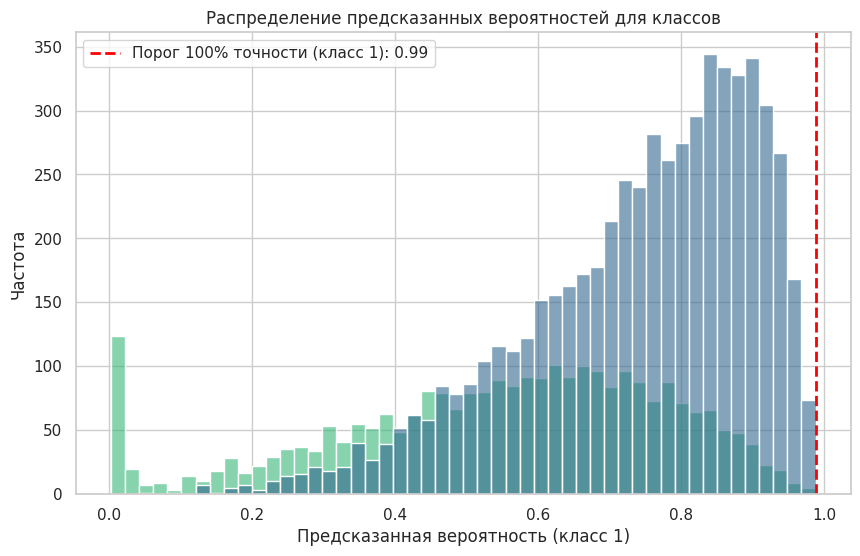

In [9]:
logger.info("Анализ результатов на отложенной выборке...")

y_proba = probas[:, 1]
# ========================
# Построение графика распределения вероятностей с использованием seaborn
# ========================
logger.info("Построение графика распределения вероятностей...")

# Вычисляем порог для 100% точности по классу 1
threshold_100 = None
for thresh in np.sort(np.unique(y_proba))[::-1]:
    y_pred_thresh = (y_proba >= thresh).astype(int)
    if y_pred_thresh.sum() == 0:
        continue
    fp = ((y_test.values == 0) & (y_pred_thresh == 1)).sum()
    if fp == 0:
        threshold_100 = thresh
        break
if threshold_100 is None:
    logger.warning(
        "Не удалось найти порог с 100% точностью для класса 1, используем минимальное значение."
    )
    threshold_100 = np.min(y_proba)
logger.info(f"Порог для 100% точности (класс 1): {threshold_100:.2f}")

# Создаем DataFrame для графика
df_prob = pd.DataFrame({"proba": y_proba, "target": y_test.values})

plt.figure(figsize=(10, 6))
sns.histplot(
    data=df_prob, x="proba", hue="target", bins=50, alpha=0.6, palette="viridis"
)
plt.axvline(
    x=threshold_100,
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Порог 100% точности (класс 1): {threshold_100:.2f}",
)
plt.xlabel("Предсказанная вероятность (класс 1)")
plt.ylabel("Частота")
plt.title("Распределение предсказанных вероятностей для классов")
plt.legend()
plt.show()

## Найдем похожие запросы с разными метками

2025-02-26 11:39:42,075 - INFO - Поиск похожих эмбеддингов для группы itsm_incident -> itsm_request


2025-02-26 11:39:46,576 - INFO - Поиск похожих эмбеддингов для группы itsm_request -> itsm_incident


Топ-10 наиболее похожих пар (по описанию):
 query_idx  candidate_idx  distance                                                                                                                                                                              query_text                                                                                                                                                                         candidate_text  query_class candidate_class
      9881          42963       0.0  "Акимова Валентина Николаевна, 119571, Москва, проспект Вернадского, д.82 стр. 1 корп.4 офис 205, моб. 8 (909) 680-05-29, тел. 8 (495) 564-86-01 доб.109, e-mail: v.akimova@ranepa.ru" "Акимова Валентина Николаевна, 119571, Москва, проспект Вернадского, д.82 стр. 1 корп.4 офис 205, моб. 8 (909) 680-05-29, тел. 8 (495) 564-86-01 доб.109, e-mail: v.akimova@ranepa.ru" itsm_request   itsm_incident
     11373          31105       0.0                                                          

In [13]:
query_global_idx

np.int64(29369)

## Bert + RF

In [3]:
import logging
import os
import re

import joblib
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

nltk.download("stopwords")
from nltk.corpus import stopwords

russian_stopwords = stopwords.words("russian")  # для очистки текста

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

# Настройка логирования и стиля
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)
logger = logging.getLogger(__name__)
sns.set(style="whitegrid")


####################################
# Трансформер очистки текста
####################################
class TextCleanerTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        def clean_text(text):
            if not isinstance(text, str):
                return ""
            text = text.lower()
            text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)
            text = re.sub(r"\W+", " ", text)
            text = re.sub(r"\s+", " ", text).strip()
            return text

        return X.apply(clean_text)


####################################
# Трансформер для извлечения эмбеддингов с использованием BERT (батчами, max_length=512)
####################################
class BertVectorizer(BaseEstimator, TransformerMixin):
    def __init__(
        self,
        model_name="bert-base-multilingual-cased",
        max_length=512,
        batch_size=32,
        device="cuda:1",
    ):
        self.model_name = model_name
        self.max_length = max_length
        self.batch_size = batch_size
        self.device = (
            device
            if device is not None
            else ("cuda" if torch.cuda.is_available() else "cpu")
        )

    def fit(self, X, y=None):
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        self.model = AutoModel.from_pretrained(self.model_name)
        self.model.to(self.device)
        self.model.eval()
        return self

    def transform(self, X):
        texts = list(X)
        embeddings = []
        with torch.no_grad():
            for i in tqdm(
                range(0, len(texts), self.batch_size), desc="Извлечение эмбеддингов"
            ):
                batch_texts = texts[i : i + self.batch_size]
                encoded = self.tokenizer(
                    batch_texts,
                    truncation=True,
                    max_length=self.max_length,
                    padding="max_length",
                    return_tensors="pt",
                )
                encoded = {k: v.to(self.device) for k, v in encoded.items()}
                output = self.model(**encoded)
                # Используем представление CLS-токена
                batch_emb = output.last_hidden_state[:, 0, :].cpu().numpy()
                embeddings.append(batch_emb)
        return np.concatenate(embeddings, axis=0)


####################################
# Функции для выбора колонок из DataFrame
####################################
# Для извлечения исходного текста из нужной колонки
def select_column(col_name):
    return lambda X: X[col_name]


####################################
# Пайплайны для извлечения эмбеддингов для каждой колонки
####################################
# Pipeline для subject
subject_bert_pipeline = Pipeline(
    [
        ("selector", FunctionTransformer(select_column("subject"), validate=False)),
        ("cleaner", TextCleanerTransformer()),
        (
            "bert",
            BertVectorizer(
                model_name="bert-base-multilingual-cased", max_length=512, batch_size=32
            ),
        ),
    ]
)
# Pipeline для description
description_bert_pipeline = Pipeline(
    [
        ("selector", FunctionTransformer(select_column("description"), validate=False)),
        ("cleaner", TextCleanerTransformer()),
        (
            "bert",
            BertVectorizer(
                model_name="bert-base-multilingual-cased", max_length=512, batch_size=32
            ),
        ),
    ]
)
# Pipeline для abstract
abstract_bert_pipeline = Pipeline(
    [
        ("selector", FunctionTransformer(select_column("abstract"), validate=False)),
        ("cleaner", TextCleanerTransformer()),
        (
            "bert",
            BertVectorizer(
                model_name="bert-base-multilingual-cased", max_length=512, batch_size=32
            ),
        ),
    ]
)

####################################
# Загрузка данных
####################################
logger.info("Загрузка данных...")
# Предполагается, что файл содержит колонки: subject, description, abstract, class
data = pd.read_csv("../data/df_llm.csv")
data["subject"] = data["subject"].fillna("no_subject")
data["description"] = data["description"].fillna("no_description")
data["abstract"] = data["abstract"].fillna("no_abstract")
X_raw = data[["subject", "description", "abstract"]]
y = data["class"]

####################################
# Извлечение эмбеддингов (один раз)
####################################
logger.info("Извлечение эмбеддингов для subject...")
subject_embeddings = subject_bert_pipeline.fit_transform(X_raw)
logger.info("Извлечение эмбеддингов для description...")
description_embeddings = description_bert_pipeline.fit_transform(X_raw)
logger.info("Извлечение эмбеддингов для abstract...")
abstract_embeddings = abstract_bert_pipeline.fit_transform(X_raw)

####################################
# Формирование наборов признаков для экспериментов
####################################
# 1. Только subject
X_subject = subject_embeddings
# 2. Только description
X_description = description_embeddings
# 3. Только abstract
X_abstract = abstract_embeddings
# 4. Комбинация: subject + description
X_subj_desc = np.concatenate([subject_embeddings, description_embeddings], axis=1)
# 5. Комбинация: subject + abstract
X_subj_abst = np.concatenate([subject_embeddings, abstract_embeddings], axis=1)


####################################
# Сбор финального комбинированного пайплайна
####################################
# Предположим, что для финального пайплайна мы хотим использовать комбинированные признаки (Subject + Abstract)
# Для финального этапа мы создаём трансформер, который подставляет предвычисленные эмбеддинги (при условии, что порядок строк совпадает)
# class PrecomputedEmbeddingsTransformer(BaseEstimator, TransformerMixin):
#     def __init__(self, subject_embeds, abstract_embeds):
#         self.subject_embeds = subject_embeds
#         self.abstract_embeds = abstract_embeds
#     def fit(self, X, y=None):
#         return self
#     def transform(self, X):
#         return np.concatenate([self.subject_embeds, self.abstract_embeds], axis=1)

# final_pipeline = Pipeline([
#     ("features", PrecomputedEmbeddingsTransformer(subject_embeddings, abstract_embeddings)),
#     ("clf", RandomForestClassifier(random_state=42, **best_model_subj_abst.get_params()))
# ])
# final_pipeline.fit(X_raw, y)
# os.makedirs("../models", exist_ok=True)
# final_model_path = os.path.join("../models", "final_rf_pipeline.pkl")
# joblib.dump(final_pipeline, final_model_path)
# logger.info(f"Финальный пайплайн сохранён по пути: {final_model_path}")

# # Пример использования финального пайплайна на новых данных:
# loaded_pipeline = joblib.load(final_model_path)
# new_data = pd.read_csv("../data/new_data.csv")  # замените путь к новым данным
# new_data["subject"] = new_data["subject"].fillna("no_subject")
# new_data["description"] = new_data["description"].fillna("no_description")
# new_data["abstract"] = new_data["abstract"].fillna("no_abstract")
# new_subject_embeds = subject_bert_pipeline.transform(new_data)
# new_abstract_embeds = abstract_bert_pipeline.transform(new_data)
# new_combined_embeds = np.concatenate([new_subject_embeds, new_abstract_embeds], axis=1)
# predictions = best_model_subj_abst.predict(new_combined_embeds)
# pred_probas = best_model_subj_abst.predict_proba(new_combined_embeds)
# logger.info("Предсказания на новых данных:")
# print(predictions)


[nltk_data] Downloading package stopwords to /home/vadim/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
2025-02-27 12:15:59,026 - INFO - Загрузка данных...
2025-02-27 12:15:59,437 - INFO - Извлечение эмбеддингов для subject...
Извлечение эмбеддингов: 100%|██████████| 1350/1350 [04:47<00:00,  4.69it/s]
2025-02-27 12:20:48,179 - INFO - Извлечение эмбеддингов для description...
Извлечение эмбеддингов: 100%|██████████| 1350/1350 [04:52<00:00,  4.62it/s]
2025-02-27 12:25:42,299 - INFO - Извлечение эмбеддингов для abstract...
Извлечение эмбеддингов: 100%|██████████| 1350/1350 [04:51<00:00,  4.63it/s]


In [31]:
####################################
# Функция для проведения эксперимента
####################################
def run_experiment(X_emb, y, exp_name="Experiment"):
    X_train, X_test, y_train, y_test = train_test_split(
        X_emb, y, test_size=0.2, random_state=42
    )
    param_grid_rf = {
        "n_estimators": [100, 200, 300],
        "max_depth": [None, 10, 20, 30],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "bootstrap": [True, False],
    }
    clf = RandomForestClassifier(n_jobs=3, random_state=42)
    grid = RandomizedSearchCV(
        clf,
        param_grid_rf,
        cv=5,
        scoring="roc_auc",
        n_jobs=5,
        verbose=1,
        n_iter=10,
        random_state=42,
    )
    grid.fit(X_train, y_train)
    y_pred = grid.predict(X_test)
    probas = grid.predict_proba(X_test)
    print(f"=== Отчёт по классификации ({exp_name}) ===")
    print(classification_report(y_test, y_pred))
    roc_auc = roc_auc_score(y_test, probas[:, 1])
    logger.info(f"{exp_name} - ROC AUC: {roc_auc}")
    return grid.best_estimator_


####################################
# Проведение экспериментов
####################################
logger.info("Эксперимент 1: Только subject")
best_model_subject = run_experiment(X_subject, y, exp_name="Subject-only")

logger.info("Эксперимент 2: Только description")
best_model_description = run_experiment(X_description, y, exp_name="Description-only")

logger.info("Эксперимент 3: Только abstract")
best_model_abstract = run_experiment(X_abstract, y, exp_name="Abstract-only")

logger.info("Эксперимент 4: Subject + Description")
best_model_subj_desc = run_experiment(X_subj_desc, y, exp_name="Subject+Description")

logger.info("Эксперимент 5: Subject + Abstract")
best_model_subj_abst = run_experiment(X_subj_abst, y, exp_name="Subject+Abstract")

2025-02-26 12:26:02,672 - INFO - Эксперимент 1: Только subject


Fitting 5 folds for each of 10 candidates, totalling 50 fits


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

=== Отчёт по классификации (Subject-only) ===
               precision    recall  f1-score   support

itsm_incident       0.72      0.31      0.43      2737
 itsm_request       0.75      0.95      0.83      5901

     accuracy                           0.74      8638
    macro avg       0.73      0.63      0.63      8638
 weighted avg       0.74      0.74      0.71      8638

Fitting 5 folds for each of 10 candidates, totalling 50 fits


2025-02-26 12:45:36,028 - INFO - Description-only - ROC AUC: 0.7513938888258382
2025-02-26 12:45:36,029 - INFO - Эксперимент 3: Только abstract


=== Отчёт по классификации (Description-only) ===
               precision    recall  f1-score   support

itsm_incident       0.75      0.23      0.36      2737
 itsm_request       0.73      0.96      0.83      5901

     accuracy                           0.73      8638
    macro avg       0.74      0.60      0.59      8638
 weighted avg       0.74      0.73      0.68      8638

Fitting 5 folds for each of 10 candidates, totalling 50 fits


2025-02-26 12:56:01,048 - INFO - Abstract-only - ROC AUC: 0.6907740041707539
2025-02-26 12:56:01,049 - INFO - Эксперимент 4: Subject + Description


=== Отчёт по классификации (Abstract-only) ===
               precision    recall  f1-score   support

itsm_incident       0.73      0.09      0.15      2737
 itsm_request       0.70      0.99      0.82      5901

     accuracy                           0.70      8638
    macro avg       0.72      0.54      0.49      8638
 weighted avg       0.71      0.70      0.61      8638

Fitting 5 folds for each of 10 candidates, totalling 50 fits


2025-02-26 13:11:09,248 - INFO - Subject+Description - ROC AUC: 0.7906541852390034
2025-02-26 13:11:09,250 - INFO - Эксперимент 5: Subject + Abstract


=== Отчёт по классификации (Subject+Description) ===
               precision    recall  f1-score   support

itsm_incident       0.80      0.28      0.41      2737
 itsm_request       0.74      0.97      0.84      5901

     accuracy                           0.75      8638
    macro avg       0.77      0.62      0.63      8638
 weighted avg       0.76      0.75      0.70      8638

Fitting 5 folds for each of 10 candidates, totalling 50 fits


2025-02-26 13:26:28,463 - INFO - Subject+Abstract - ROC AUC: 0.7696387854228803


=== Отчёт по классификации (Subject+Abstract) ===
               precision    recall  f1-score   support

itsm_incident       0.78      0.25      0.38      2737
 itsm_request       0.74      0.97      0.84      5901

     accuracy                           0.74      8638
    macro avg       0.76      0.61      0.61      8638
 weighted avg       0.75      0.74      0.69      8638



## Близость разных меток

In [1]:
import faiss

df = data.copy()

# Получаем уникальные классы (предполагается бинарная классификация)
unique_classes = np.unique(y)
if len(unique_classes) != 2:
    raise ValueError(
        "Ожидается бинарная классификация, найдено: {}".format(unique_classes)
    )
class_A, class_B = unique_classes

# Разбиваем индексы по классам
indices_A = np.where(y == class_A)[0]
indices_B = np.where(y == class_B)[0]
embeddings_A = description_embeddings[indices_A]
embeddings_B = description_embeddings[indices_B]


def search_opposite_class(query_embeddings, target_embeddings, topk=1):
    d = target_embeddings.shape[1]
    index = faiss.IndexFlatL2(d)
    index.add(target_embeddings)
    distances, indices = index.search(query_embeddings, topk)
    return distances, indices


# Параметр topk (по умолчанию 1)
topk = 5

# Поиск для группы A: для каждого вектора из A находим topk ближайших в группе B
logger.info("Поиск похожих эмбеддингов для группы {} -> {}".format(class_A, class_B))
distances_A, indices_A_candidates = search_opposite_class(
    embeddings_A, embeddings_B, topk=topk
)
# # Аналогично для группы B: для каждого вектора из B ищем топ ближайших в группе A
logger.info("Поиск похожих эмбеддингов для группы {} -> {}".format(class_B, class_A))
distances_B, indices_B_candidates = search_opposite_class(
    embeddings_B, embeddings_A, topk=topk
)

# Собираем результаты в список троек: (индекс запроса, индекс кандидата, расстояние)
results = []

# Для группы A: преобразуем локальные индексы кандидатов в глобальные
for i, (dist_row, cand_indices) in enumerate(zip(distances_A, indices_A_candidates)):
    query_global_idx = indices_A[i]
    # cand_indices содержат локальные индексы в embeddings_B
    global_cand_indices = [indices_B[cand] for cand in cand_indices]
    results.append((query_global_idx, global_cand_indices, dist_row.tolist()))

# Для группы B:
for i, (dist_row, cand_indices) in enumerate(zip(distances_B, indices_B_candidates)):
    query_global_idx = indices_B[i]
    global_cand_indices = [indices_A[cand] for cand in cand_indices]
    results.append((query_global_idx, global_cand_indices, dist_row.tolist()))

# Сортируем результаты по расстоянию (по первому кандидату)
results_sorted = sorted(results, key=lambda x: x[2][0])

# Сохраняем результаты в DataFrame для удобства
# Создадим колонки: query_idx, candidate_idx, distance, query_text, candidate_text, query_class, candidate_class
res_data = []
for query_idx, cand_list, dist_list in results_sorted:
    for cand_idx, dist in zip(cand_list, dist_list):
        query_text = df.loc[query_idx, "description"]
        candidate_text = df.loc[cand_idx, "description"]
        query_class = y[query_idx]
        candidate_class = y[cand_idx]
        res_data.append(
            {
                "query_idx": query_idx,
                "candidate_idx": cand_idx,
                "distance": dist,
                "query_text": query_text,
                "candidate_text": candidate_text,
                "query_class": query_class,
                "candidate_class": candidate_class,
            }
        )

results_df = pd.DataFrame(res_data)
# Сохраняем DataFrame с результатами
output_results_path = "../results/most_similar.csv"
results_df.to_csv(output_results_path, index=False)
logger.info(f"Результаты поиска похожих эмбеддингов сохранены в {output_results_path}")

# Выводим топ-10 наиболее похожих пар (с наименьшими расстояниями)
print("Топ-10 наиболее похожих пар (по описанию):")
print(results_df.sort_values("distance").head(10).to_string(index=False))

NameError: name 'data' is not defined

In [10]:
results_df[results_df["distance"] < 1.5]

,query_idx,candidate_idx,distance,query_text,candidate_text,query_class,candidate_class
0,29460,26373,0.000000,Добрый день!\nПросьба провести приказ.,Добрый день! Просьба провести приказ.,itsm_incident,itsm_request
5,29574,390,0.000000,"\n\n-- \n С уважением,\n Акимова Вале...","\n\n-- \n С уважением,\n Акимова Вале...",itsm_incident,itsm_request
6,29574,540,0.000000,"\n\n-- \n С уважением,\n Акимова Вале...","\n\n-- \n С уважением,\n Акимова Вале...",itsm_incident,itsm_request
7,29574,583,0.000000,"\n\n-- \n С уважением,\n Акимова Вале...","\n-- \n С уважением,\n Акимова Валент...",itsm_incident,itsm_request
8,29574,726,0.000000,"\n\n-- \n С уважением,\n Акимова Вале...","\n-- \n С уважением,\n Акимова Валент...",itsm_incident,itsm_request
...,...,...,...,...,...,...,...
2245,34952,15306,1.486374,"Добрый день!\n \nМожно, пожалуйста, исправить ...",Добрый день!\n \nПросьба абитуриента Просянкин...,itsm_incident,itsm_request
2250,35682,20593,1.487381,"Коллеги, здравствуйте.\nКонкурсные списки неко...",Здравствуйте.\nНе можем принять заявление\n\nК...,itsm_incident,itsm_request
2255,41182,27366,1.492279,"Добрый день!\nПытаемся восстановить приказы, к...",\n\nДобрый день!\nПытаемся восстановить прика...,itsm_incident,itsm_request
2260,39844,27693,1.495361,"Добрый день!\nПроведите, пожалуйста, приказ на...","Добрый день!\nПроведите, пожалуйста, приказ на...",itsm_incident,itsm_request


<Axes: >

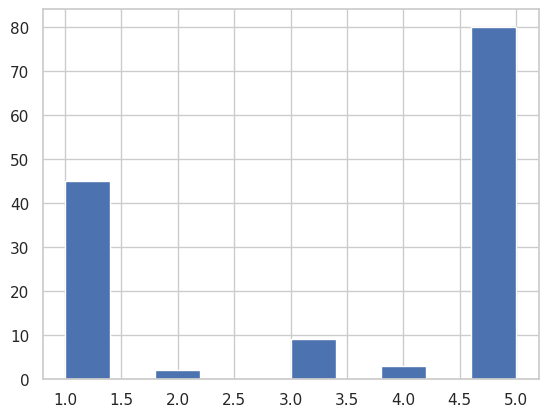

In [ ]:
results_df[results_df["distance"] == 0].groupby("query_idx")[
    "candidate_idx"
].count().hist()

## NEW EMB

In [4]:
import logging
import os

import nltk
import numpy as np
import pandas as pd
import seaborn as sns

os.environ["TOKENIZERS_PARALLELISM"] = "false"

nltk.download("stopwords")
from nltk.corpus import stopwords

russian_stopwords = stopwords.words("russian")  # для очистки текста

from tqdm import tqdm
import torch
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from transformers import AutoModel, AutoTokenizer


# Настройка логирования и стиля
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)
logger = logging.getLogger(__name__)
sns.set(style="whitegrid")


####################################
# Трансформер очистки текста
####################################
class TextCleanerTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        def clean_text(text):
            if not isinstance(text, str):
                return ""
            text = text.lower()
            text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)
            text = re.sub(r"\W+", " ", text)
            text = re.sub(r"\s+", " ", text).strip()
            return text

        return X.apply(clean_text)


####################################
# Трансформер для извлечения эмбеддингов с использованием intfloat/multilingual-e5-large
# Используем mean pooling по токенам с учетом attention mask
####################################
class E5Vectorizer(BaseEstimator, TransformerMixin):
    def __init__(
        self,
        model_name="intfloat/multilingual-e5-large",
        max_length=512,
        batch_size=32,
        device="cuda:1",
    ):
        self.model_name = model_name
        self.max_length = max_length
        self.batch_size = batch_size
        self.device = (
            device
            if device is not None
            else ("cuda" if torch.cuda.is_available() else "cpu")
        )

    def fit(self, X, y=None):
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        self.model = AutoModel.from_pretrained(self.model_name)
        self.model.to(self.device)
        self.model.eval()
        return self

    def transform(self, X):
        texts = list(X)
        embeddings = []
        with torch.no_grad():
            for i in tqdm(
                range(0, len(texts), self.batch_size), desc="Извлечение эмбеддингов"
            ):
                batch_texts = texts[i : i + self.batch_size]
                encoded = self.tokenizer(
                    batch_texts,
                    truncation=True,
                    max_length=self.max_length,
                    padding="max_length",
                    return_tensors="pt",
                )
                encoded = {k: v.to(self.device) for k, v in encoded.items()}
                output = self.model(**encoded)
                token_embeddings = (
                    output.last_hidden_state
                )  # (batch_size, seq_length, hidden_size)
                attention_mask = encoded["attention_mask"]  # (batch_size, seq_length)
                # Расширяем маску для перемножения с эмбеддингами
                input_mask_expanded = (
                    attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
                )
                sum_embeddings = torch.sum(
                    token_embeddings * input_mask_expanded, dim=1
                )
                sum_mask = torch.clamp(input_mask_expanded.sum(dim=1), min=1e-9)
                batch_emb = (sum_embeddings / sum_mask).cpu().numpy()
                embeddings.append(batch_emb)
        return np.concatenate(embeddings, axis=0)


####################################
# Функции для выбора колонок из DataFrame
####################################
def select_column(col_name):
    return lambda X: X[col_name]


####################################
# Пайплайны для извлечения эмбеддингов для каждой колонки
####################################
# Pipeline для subject
subject_e5_pipeline = Pipeline(
    [
        ("selector", FunctionTransformer(select_column("subject"), validate=False)),
        # ("cleaner", TextCleanerTransformer()),  # при необходимости можно раскомментировать
        (
            "e5",
            E5Vectorizer(
                model_name="intfloat/multilingual-e5-large",
                max_length=512,
                batch_size=32,
            ),
        ),
    ]
)
# Pipeline для description
description_e5_pipeline = Pipeline(
    [
        ("selector", FunctionTransformer(select_column("description"), validate=False)),
        # ("cleaner", TextCleanerTransformer()),
        (
            "e5",
            E5Vectorizer(
                model_name="intfloat/multilingual-e5-large",
                max_length=512,
                batch_size=32,
            ),
        ),
    ]
)
# Pipeline для abstract
abstract_e5_pipeline = Pipeline(
    [
        ("selector", FunctionTransformer(select_column("abstract"), validate=False)),
        # ("cleaner", TextCleanerTransformer()),
        (
            "e5",
            E5Vectorizer(
                model_name="intfloat/multilingual-e5-large",
                max_length=512,
                batch_size=32,
            ),
        ),
    ]
)

####################################
# Загрузка данных
####################################
logger.info("Загрузка данных...")
# Предполагается, что файл содержит колонки: subject, description, abstract, class
data = pd.read_csv("../data/df_llm.csv")
data["subject"] = data["subject"].fillna("no_subject")
data["description"] = data["description"].fillna("no_description")
data["abstract"] = data["abstract"].fillna("no_abstract")
X_raw = data[["subject", "description", "abstract"]]
y = data["class"]

####################################
# Извлечение эмбеддингов (один раз)
####################################
logger.info("Извлечение эмбеддингов для subject...")
subject_embeddings = subject_e5_pipeline.fit_transform(X_raw)
logger.info("Извлечение эмбеддингов для description...")
description_embeddings = description_e5_pipeline.fit_transform(X_raw)
logger.info("Извлечение эмбеддингов для abstract...")
abstract_embeddings = abstract_e5_pipeline.fit_transform(X_raw)

####################################
# Формирование наборов признаков для экспериментов
####################################
# 1. Только subject
X_subject = subject_embeddings
# 2. Только description
X_description = description_embeddings
# 3. Только abstract
X_abstract = abstract_embeddings
# 4. Комбинация: subject + description
X_subj_desc = np.concatenate(
    [
        subject_embeddings,
        description_embeddings,
    ],
    axis=1,
)

X_subj_abs = np.concatenate(
    [
        subject_embeddings,
        abstract_embeddings,
    ],
    axis=1,
)


[nltk_data] Downloading package stopwords to /home/vadim/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
2025-02-28 19:31:00,649 - INFO - Загрузка данных...
2025-02-28 19:31:01,055 - INFO - Извлечение эмбеддингов для subject...
Извлечение эмбеддингов: 100%|██████████| 1350/1350 [14:54<00:00,  1.51it/s]
2025-02-28 19:45:58,348 - INFO - Извлечение эмбеддингов для description...
Извлечение эмбеддингов: 100%|██████████| 1350/1350 [15:08<00:00,  1.49it/s]
2025-02-28 20:01:10,484 - INFO - Извлечение эмбеддингов для abstract...
Извлечение эмбеддингов: 100%|██████████| 1350/1350 [15:05<00:00,  1.49it/s]


In [5]:
####################################
# Функция для проведения эксперимента
####################################
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, roc_auc_score
import logging


####################################
# Функция для проведения эксперимента с KNN
####################################
def run_experiment(X_emb, y, exp_name="Experiment"):
    # Разбиваем данные на обучающую и тестовую выборки
    X_train, X_test, y_train, y_test = train_test_split(
        X_emb, y, test_size=0.2, random_state=42
    )

    # Расширенный набор гиперпараметров для KNeighborsClassifier
    param_grid_knn = {
        "n_neighbors": [3, 5, 7, 9, 11],
        "weights": ["uniform", "distance"],
        "p": [1, 2],  # 1: Manhattan, 2: Euclidean
        "algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
        # Можно добавить "leaf_size" для некоторых алгоритмов, если требуется:
        "leaf_size": [20, 30, 40, 50],
    }

    clf = KNeighborsClassifier()
    grid = RandomizedSearchCV(
        clf,
        param_grid_knn,
        cv=5,
        scoring="roc_auc",
        n_jobs=5,
        verbose=1,
        n_iter=10,
        random_state=42,
    )

    grid.fit(X_train, y_train)
    y_pred = grid.predict(X_test)
    probas = grid.predict_proba(X_test)

    print(f"=== Отчёт по классификации ({exp_name}) ===")
    print(classification_report(y_test, y_pred))

    # Для бинарной классификации roc_auc вычисляется по столбцу с индексом 1
    roc_auc = roc_auc_score(y_test, probas[:, 1])
    logging.getLogger(__name__).info(f"{exp_name} - ROC AUC: {roc_auc}")

    return grid.best_estimator_


####################################
# Проведение экспериментов
####################################
logger.info("Эксперимент 1: Только subject")
best_model_subject = run_experiment(X_subject, y, exp_name="Subject-only")

logger.info("Эксперимент 2: Только description")
best_model_description = run_experiment(X_description, y, exp_name="Description-only")

logger.info("Эксперимент 3: Только abstract")
best_model_abstract = run_experiment(X_abstract, y, exp_name="Abstract-only")

logger.info("Эксперимент 4: Subject + Description")
best_model_subj_desc = run_experiment(X_subj_desc, y, exp_name="Subject+Description")

logger.info("Эксперимент 5: Subject + Abstract")
best_model_subj_abst = run_experiment(X_subj_abst, y, exp_name="Subject+Abstract")

2025-02-28 20:16:22,325 - INFO - Эксперимент 1: Только subject


Fitting 5 folds for each of 10 candidates, totalling 50 fits


/media/admin01/storage4/vadim/request_classifier/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/media/admin01/storage4/vadim/request_classifier/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/media/admin01/storage4/vadim/request_classifier/.venv/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/media/admin01/storage4/vadim/request_classifier/.venv/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 

=== Отчёт по классификации (Subject-only) ===
               precision    recall  f1-score   support

itsm_incident       0.61      0.54      0.57      2737
 itsm_request       0.80      0.84      0.82      5901

     accuracy                           0.75      8638
    macro avg       0.70      0.69      0.70      8638
 weighted avg       0.74      0.75      0.74      8638

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/media/admin01/storage4/vadim/request_classifier/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/media/admin01/storage4/vadim/request_classifier/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/media/admin01/storage4/vadim/request_classifier/.venv/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/media/admin01/storage4/vadim/request_classifier/.venv/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 

=== Отчёт по классификации (Description-only) ===
               precision    recall  f1-score   support

itsm_incident       0.67      0.54      0.60      2737
 itsm_request       0.80      0.87      0.84      5901

     accuracy                           0.77      8638
    macro avg       0.74      0.71      0.72      8638
 weighted avg       0.76      0.77      0.76      8638

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/media/admin01/storage4/vadim/request_classifier/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/media/admin01/storage4/vadim/request_classifier/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/media/admin01/storage4/vadim/request_classifier/.venv/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/media/admin01/storage4/vadim/request_classifier/.venv/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 

=== Отчёт по классификации (Abstract-only) ===
               precision    recall  f1-score   support

itsm_incident       0.60      0.50      0.54      2737
 itsm_request       0.78      0.85      0.81      5901

     accuracy                           0.74      8638
    macro avg       0.69      0.67      0.68      8638
 weighted avg       0.73      0.74      0.73      8638

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/media/admin01/storage4/vadim/request_classifier/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/media/admin01/storage4/vadim/request_classifier/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/media/admin01/storage4/vadim/request_classifier/.venv/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/media/admin01/storage4/vadim/request_classifier/.venv/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 

=== Отчёт по классификации (Subject+Description) ===
               precision    recall  f1-score   support

itsm_incident       0.67      0.56      0.61      2737
 itsm_request       0.81      0.87      0.84      5901

     accuracy                           0.77      8638
    macro avg       0.74      0.71      0.72      8638
 weighted avg       0.76      0.77      0.77      8638



NameError: name 'X_subj_abst' is not defined